In [308]:
# leer df_sin_anomalos.csv
import pandas as pd
df = pd.read_csv('df_sin_anomalos.csv')
df_final = pd.read_csv("df_final.csv")

In [309]:
# dividir en train y test segun indice_test.csv y indice_train.csv
indice_test = pd.read_csv("indices_test.csv")
indice_train = pd.read_csv("indices_train.csv")

df_test = df_final.iloc[indice_test["0"],:]
df_train = df_final.iloc[indice_train["0"],:]

In [310]:
X_test_todos = df_test.drop(['TRT'], axis=1)
y_test = pd.DataFrame(df_test["TRT"])

X_train_todos = df_train.drop(['TRT'], axis=1)
y_train = pd.DataFrame(df_train["TRT"])

In [312]:
X_test_final = X_test_todos[["ARTERIOPATIA_PERIFERICA","ENFERMEDAD_VASCULAR","SAME_MAS_DE_2","N_PASTILLAS_D_INICIO","NEOPLASIA_NO","ADE","MONOCITOS","DISLIPEMIA","AMIODARONA","EDAD","INSUFICIENCIA_CARDIACA","SAME-TT2R2_MAS3","NEUTROFILOS"]]
X_train_final = X_train_todos[["ARTERIOPATIA_PERIFERICA","ENFERMEDAD_VASCULAR","SAME_MAS_DE_2","N_PASTILLAS_D_INICIO","NEOPLASIA_NO","ADE","MONOCITOS","DISLIPEMIA","AMIODARONA","EDAD","INSUFICIENCIA_CARDIACA","SAME-TT2R2_MAS3","NEUTROFILOS"]]

In [313]:
y_train["TRT_60"] = 0
y_train.loc[y_train["TRT"] >= 60, "TRT_60"] = 1

y_test["TRT_60"] = 0
y_test.loc[y_test["TRT"] >= 60, "TRT_60"] = 1

y_train["TRT_65"] = 0
y_train.loc[y_train["TRT"] >= 65, "TRT_65"] = 1

y_test["TRT_65"] = 0
y_test.loc[y_test["TRT"] >= 65, "TRT_65"] = 1

y_train["TRT_70"] = 0
y_train.loc[y_train["TRT"] >= 70, "TRT_70"] = 1

y_test["TRT_70"] = 0
y_test.loc[y_test["TRT"] >= 70, "TRT_70"] = 1

In [316]:
# undersampling + oversampling
from imblearn.over_sampling import ADASYN
sm = ADASYN(random_state=123)
X_train_todos60, y_train_bi60t = sm.fit_resample(X_train_todos, y_train["TRT_60"])
X_train_final60, y_train_bi60 = sm.fit_resample(X_train_final, y_train["TRT_60"])
X_train_todos65, y_train_bi65t = sm.fit_resample(X_train_todos, y_train["TRT_65"])
X_train_final65, y_train_bi65 = sm.fit_resample(X_train_final, y_train["TRT_65"])
X_train_todos70, y_train_bi70t = sm.fit_resample(X_train_todos, y_train["TRT_70"])
X_train_final70, y_train_bi70 = sm.fit_resample(X_train_final, y_train["TRT_70"])

In [317]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve

from sklearn.model_selection import GridSearchCV
from scipy.optimize import minimize
from sklearn.metrics import balanced_accuracy_score
# warnings
import warnings

# numpy
import numpy as np

# time
import time


# make scorer
from sklearn.metrics import make_scorer

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

def train_model_gridsearch2(model, X_train, X_val, y_train, y_val, params,DF):
    warnings.filterwarnings('ignore')
    grid = GridSearchCV(model, params, cv=5, scoring=scoring, refit="precision")
    grid.fit(X_train, y_train)
    print("Best params: ", grid.best_params_)
    print("Best score: ", grid.best_score_)
    start_time = time.time()
    y_pred = grid.predict(X_val)
    execution_time = (time.time() - start_time)
    print("F1: ", f1_score(y_val, y_pred))
    print("Precision: ", precision_score(y_val, y_pred))
    print("Recall: ", recall_score(y_val, y_pred))
    print("Balanced accuracy: ", accuracy_score(y_val, y_pred))
    # negative predictive value
    print("Negative predictive value: ", np.round(confusion_matrix(y_val, y_pred)[0][0]/(confusion_matrix(y_val, y_pred)[0][0]+confusion_matrix(y_val, y_pred)[1][0]), 2))
    # positive predictive value
    print("Positive predictive value: ", np.round(confusion_matrix(y_val, y_pred)[1][1]/(confusion_matrix(y_val, y_pred)[1][1]+confusion_matrix(y_val, y_pred)[0][1]), 2))
    print()

    # classification report
    print(classification_report(y_val, y_pred))

    # confusion matrix con seaborn
    cm = confusion_matrix(y_val,y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    # axes
    plt.xlabel("Predicted")
    # title
    plt.title("Confusion Matrix")
    plt.ylabel("True")
    plt.show()
    
    # plot roc curve
    try:
        y_pred_proba = grid.predict_proba(X_val)[::,1]
        fpr, tpr, _ = roc_curve(y_val,  y_pred_proba)
        auc = roc_auc_score(y_val, y_pred_proba)
        print(auc)
        plt.plot(fpr,tpr,label="auc="+str(auc))
        # axes
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        # linea diagonal en gris claro
        plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        # titulo
        plt.title("ROC Curve")
        plt.legend(loc=4)
        plt.show()
        precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

        # Plot the precision-recall curve
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        plt.show()

        # predict probabilit
        # reliability diagram
        fop, mpv = calibration_curve(y_val, y_pred_proba, n_bins=10, normalize=True)
        # plot perfectly calibrated
        plt.plot([0, 1], [0, 1], linestyle='--')
        # plot model reliability
        plt.plot(mpv, fop, marker='.')
        plt.xlabel('Mean predicted value')
        plt.ylabel('Fraction of positives')
        plt.title('Calibration Curve')
        plt.grid(True)
        plt.show()

        DF = DF.append({"Modelo": str(model), "F1": f1_score(y_val, y_pred), "Precision": precision_score(y_val, y_pred), "Recall": recall_score(y_val, y_pred), "Balanced accuracy": balanced_accuracy_score(y_val, y_pred), "NPV": np.round(confusion_matrix(y_val, y_pred)[0][0]/(confusion_matrix(y_val, y_pred)[0][0]+confusion_matrix(y_val, y_pred)[1][0]), 2), "PPV": np.round(confusion_matrix(y_val, y_pred)[1][1]/(confusion_matrix(y_val, y_pred)[1][1]+confusion_matrix(y_val, y_pred)[0][1]), 2), "Time": execution_time, "AUC": roc_auc_score(y_val, y_pred_proba),"FPR":fpr,"TPR":tpr,"FOP":fop,"MPV":mpv}, ignore_index=True)
    except:
        fpr, tpr, _ = roc_curve(y_val,  y_pred)
        fop, mpv = calibration_curve(y_val, y_pred, n_bins=10, normalize=True)
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        DF = DF.append({"Modelo": str(model), "F1": f1_score(y_val, y_pred), "Precision": precision_score(y_val, y_pred), "Recall": recall_score(y_val, y_pred), "Balanced accuracy": balanced_accuracy_score(y_val, y_pred), "NPV": np.round(confusion_matrix(y_val, y_pred)[0][0]/(confusion_matrix(y_val, y_pred)[0][0]+confusion_matrix(y_val, y_pred)[1][0]), 2), "PPV": np.round(confusion_matrix(y_val, y_pred)[1][1]/(confusion_matrix(y_val, y_pred)[1][1]+confusion_matrix(y_val, y_pred)[0][1]), 2), "Time": execution_time, "AUC": roc_auc_score(y_val, y_pred),"FPR":fpr,"TPR":tpr,"FOP":fop,"MPV":mpv}, ignore_index=True)

    return DF

In [281]:
SAME = pd.DataFrame(columns=["Modelo", "F1", "Precision", "Recall", "Balanced accuracy", "NPV", "PPV", "Time", "AUC","FPR","TPR","FOP","MPV","Cost"])

In [318]:
TODAS2 = pd.DataFrame(columns=["Modelo", "F1", "Precision", "Recall", "Balanced accuracy", "NPV", "PPV", "Time", "AUC", "FPR", "TPR", "PR", "RE","Cost"])
SIGNIFICATIVAS2 = pd.DataFrame(columns=["Modelo", "F1", "Precision", "Recall", "Balanced accuracy", "NPV", "PPV", "Time", "AUC", "FPR", "TPR", "PR", "RE","Cost"])

TODAS3 = pd.DataFrame(columns=["Modelo", "F1", "Precision", "Recall", "Balanced accuracy", "NPV", "PPV", "Time", "AUC", "FPR", "TPR", "PR", "RE","Cost"])
SIGNIFICATIVAS3 = pd.DataFrame(columns=["Modelo", "F1", "Precision", "Recall", "Balanced accuracy", "NPV", "PPV", "Time", "AUC", "FPR", "TPR", "PR", "RE","Cost"])

TODAS4 = pd.DataFrame(columns=["Modelo", "F1", "Precision", "Recall", "Balanced accuracy", "NPV", "PPV", "Time", "AUC", "FPR", "TPR", "PR", "RE","Cost"])
SIGNIFICATIVAS4 = pd.DataFrame(columns=["Modelo", "F1", "Precision", "Recall", "Balanced accuracy", "NPV", "PPV", "Time", "AUC", "FPR", "TPR", "PR", "RE","Cost"])

Model:  AdaBoostClassifier
Best params:  {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 100}
Best score:  0.6733333333333332
F1:  0.08247422680412371
Precision:  0.3333333333333333
Recall:  0.047058823529411764
Accuracy:  0.555
Negative predictive value:  0.57
Positive predictive value:  0.33
Cost:  91.0

F1 train:  0.13756613756613756
Precision train:  0.7222222222222222
Recall train:  0.07602339181286549
Accuracy train:  0.5925
Negative predictive value train:  0.59
Positive predictive value train:  0.72
Cost train:  328.5
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       115
           1       0.33      0.05      0.08        85

    accuracy                           0.56       200
   macro avg       0.45      0.49      0.39       200
weighted avg       0.47      0.56      0.44       200



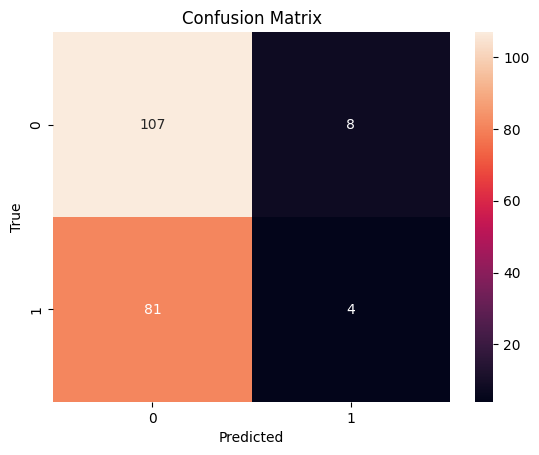

0.5286956521739131


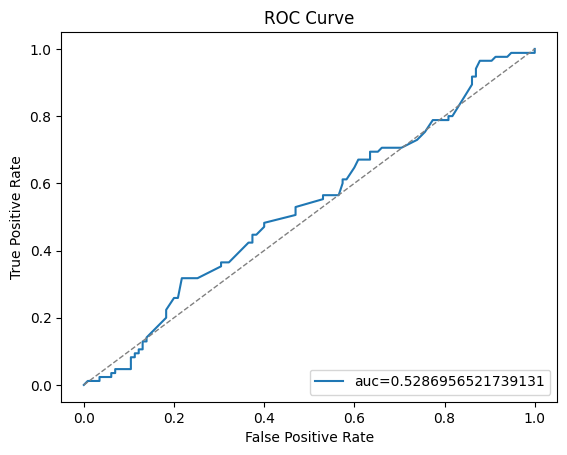

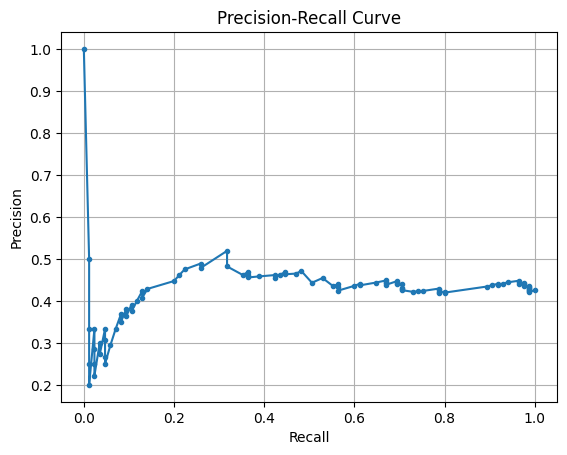

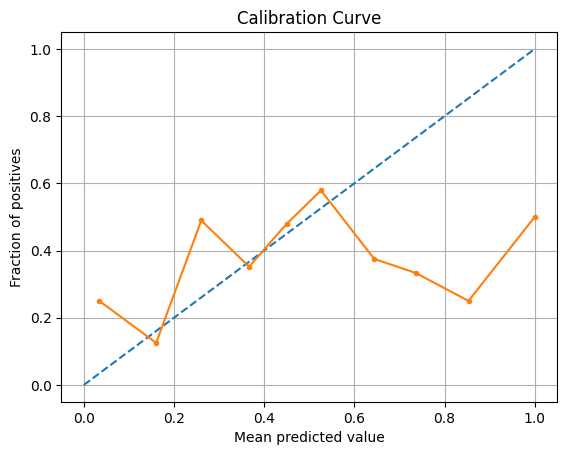

Best params:  {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 300}
Best score:  0.538888888888889
F1:  0.10869565217391305
Precision:  0.7142857142857143
Recall:  0.058823529411764705
Accuracy:  0.59
Negative predictive value:  0.59
Positive predictive value:  0.71
Cost:  82.5

F1 train:  0.17215189873417722
Precision train:  0.6415094339622641
Recall train:  0.09941520467836257
Accuracy train:  0.59125
Negative predictive value train:  0.59
Positive predictive value train:  0.64
Cost train:  331.75
              precision    recall  f1-score   support

           0       0.59      0.98      0.73       115
           1       0.71      0.06      0.11        85

    accuracy                           0.59       200
   macro avg       0.65      0.52      0.42       200
weighted avg       0.64      0.59      0.47       200



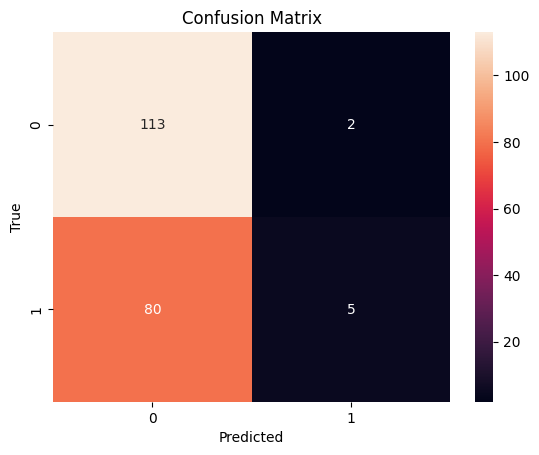

0.5617391304347826


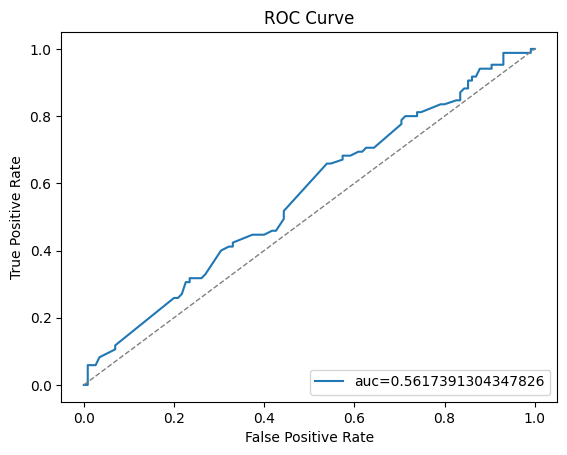

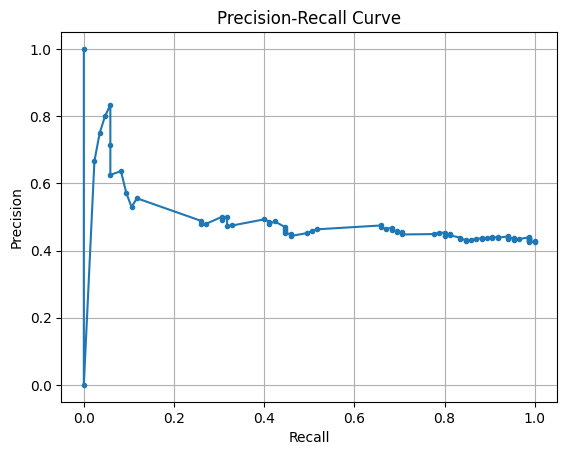

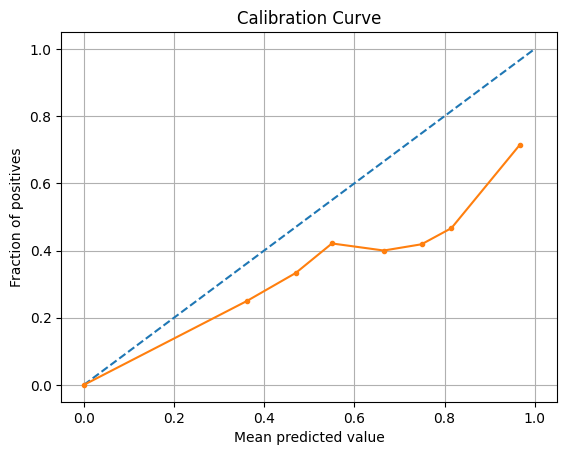

Best params:  {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 500}
Best score:  0.595891838050302
F1:  0.29411764705882354
Precision:  0.2898550724637681
Recall:  0.29850746268656714
Accuracy:  0.52
Negative predictive value:  0.64
Positive predictive value:  0.29
Cost:  108.25

F1 train:  0.7238095238095238
Precision train:  0.7307692307692307
Recall train:  0.7169811320754716
Accuracy train:  0.7256385998107853
Negative predictive value train:  0.72
Positive predictive value train:  0.73
Cost train:  325.0
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       133
           1       0.29      0.30      0.29        67

    accuracy                           0.52       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.52      0.52      0.52       200



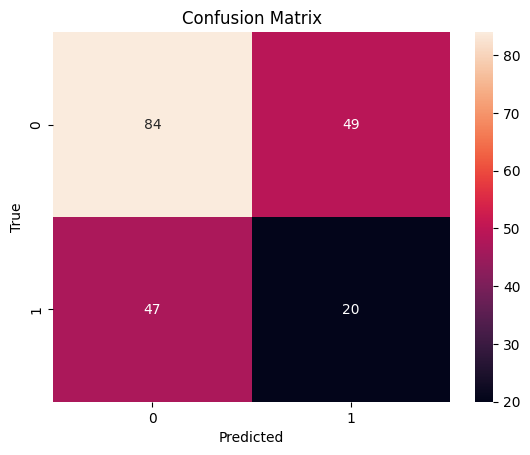

0.4960161598024913


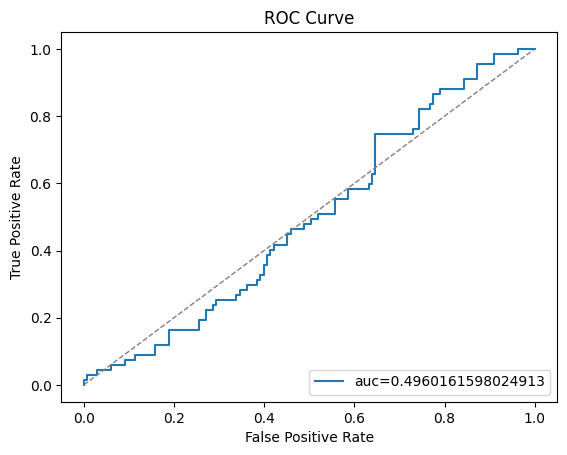

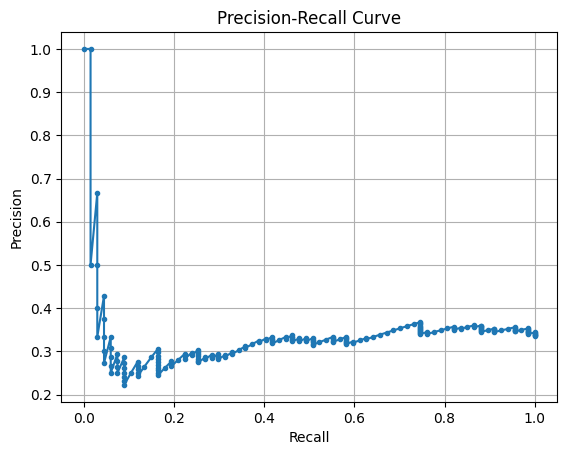

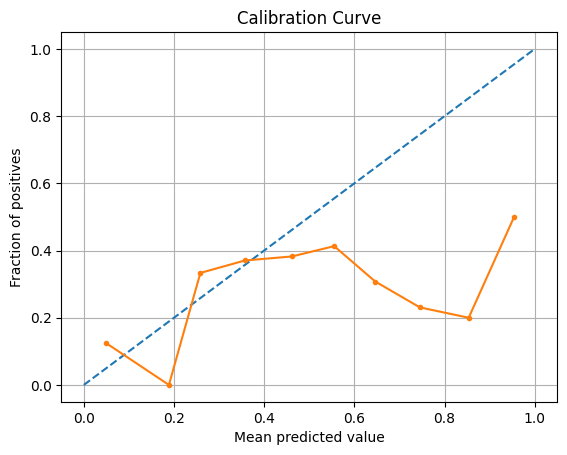

Best params:  {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 400}
Best score:  0.6139473519030857
F1:  0.30158730158730157
Precision:  0.3220338983050847
Recall:  0.2835820895522388
Accuracy:  0.56
Negative predictive value:  0.66
Positive predictive value:  0.32
Cost:  98.0

F1 train:  0.7696793002915452
Precision train:  0.8
Recall train:  0.7415730337078652
Accuracy train:  0.7766258246936852
Negative predictive value train:  0.76
Positive predictive value train:  0.8
Cost train:  261.75
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       133
           1       0.32      0.28      0.30        67

    accuracy                           0.56       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.55      0.56      0.55       200



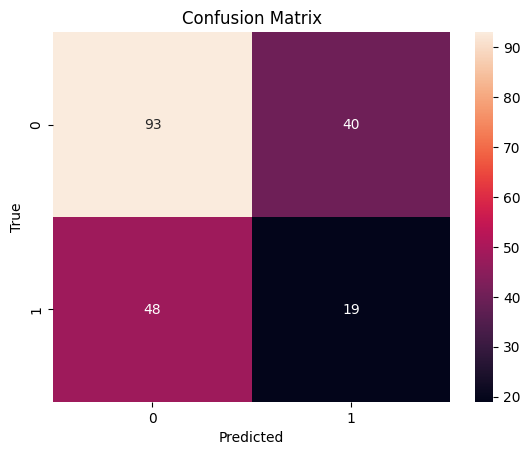

0.5481988553473235


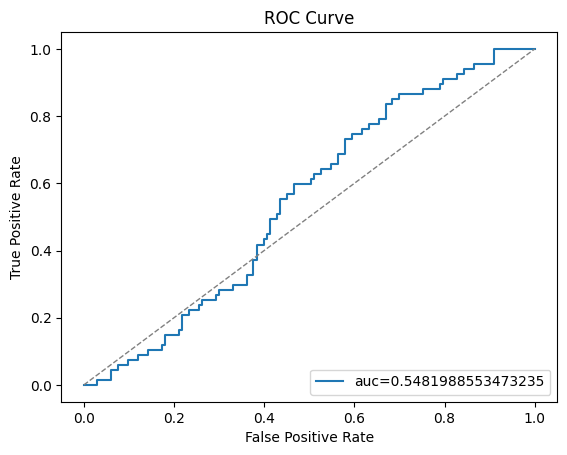

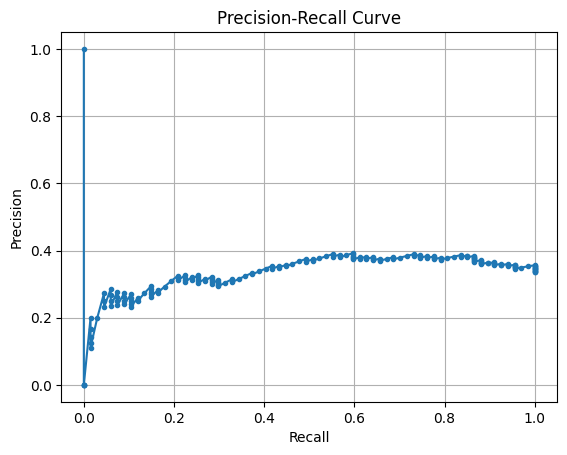

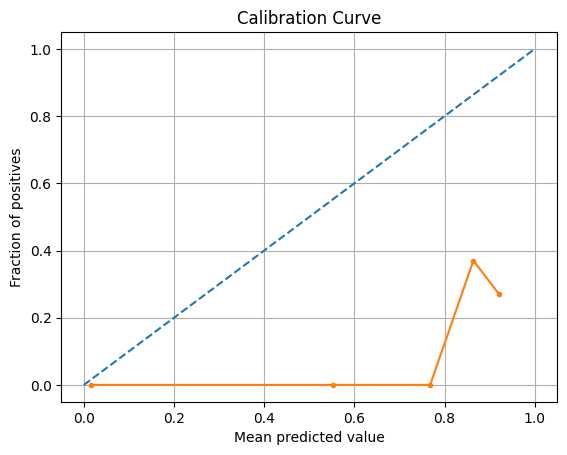

Best params:  {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 500}
Best score:  0.6581770182912707
F1:  0.2601626016260163
Precision:  0.25
Recall:  0.2711864406779661
Accuracy:  0.545
Negative predictive value:  0.68
Positive predictive value:  0.25
Cost:  103.0

F1 train:  0.7535460992907801
Precision train:  0.7602862254025045
Recall train:  0.7469244288224957
Accuracy train:  0.7550660792951542
Negative predictive value train:  0.75
Positive predictive value train:  0.76
Cost train:  311.5
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       141
           1       0.25      0.27      0.26        59

    accuracy                           0.55       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.56      0.55      0.55       200



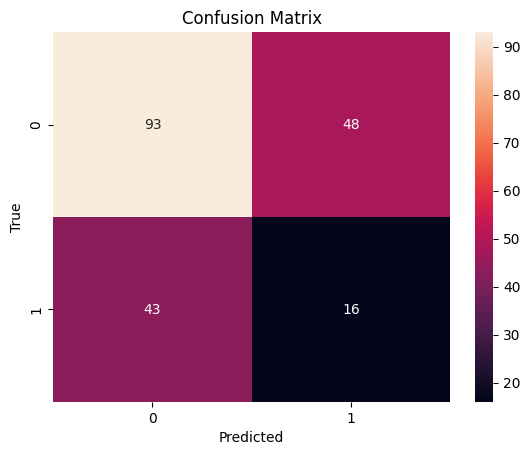

0.49020314941699716


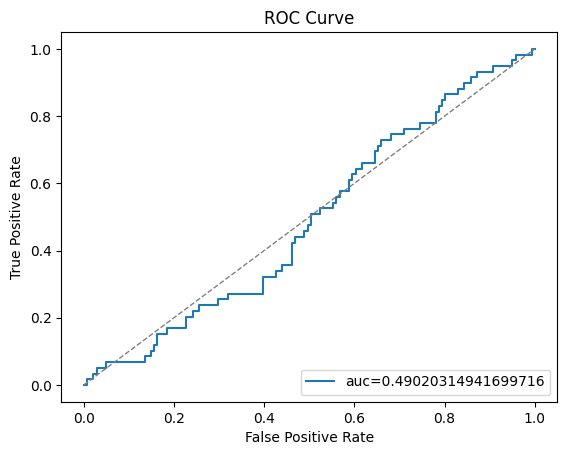

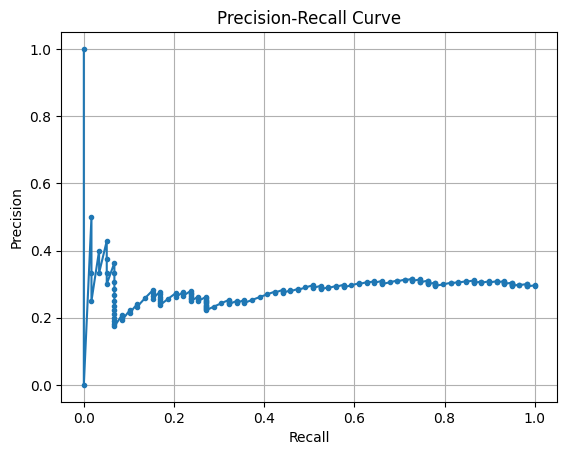

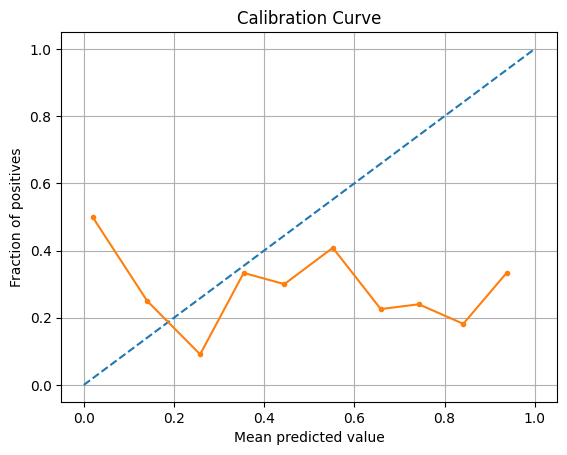

Best params:  {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 400}
Best score:  0.6783763154638269
F1:  0.2745098039215686
Precision:  0.32558139534883723
Recall:  0.23728813559322035
Accuracy:  0.63
Negative predictive value:  0.71
Positive predictive value:  0.33
Cost:  81.25

F1 train:  0.8064516129032259
Precision train:  0.8458646616541353
Recall train:  0.7705479452054794
Accuracy train:  0.8121739130434783
Negative predictive value train:  0.78
Positive predictive value train:  0.85
Cost train:  236.5
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       141
           1       0.33      0.24      0.27        59

    accuracy                           0.63       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.60      0.63      0.61       200



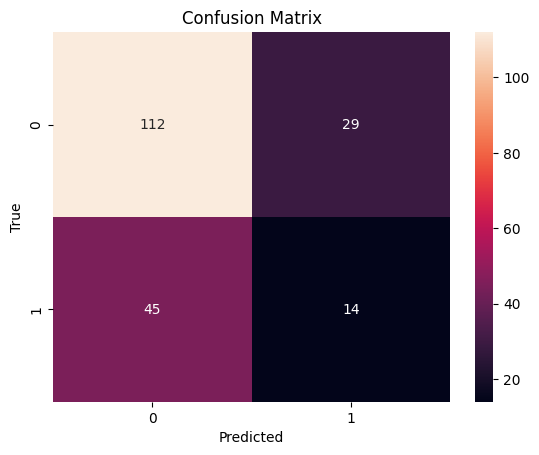

0.5602836879432623


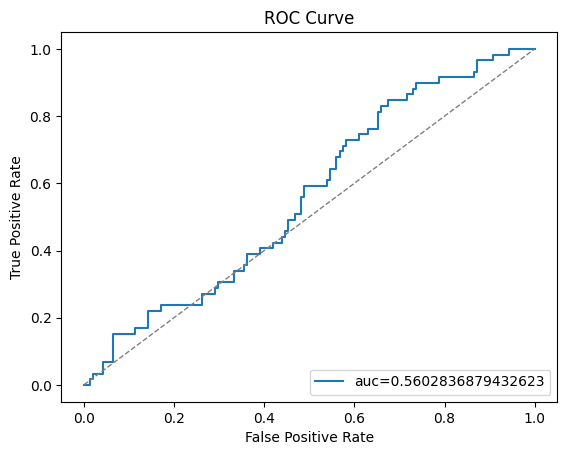

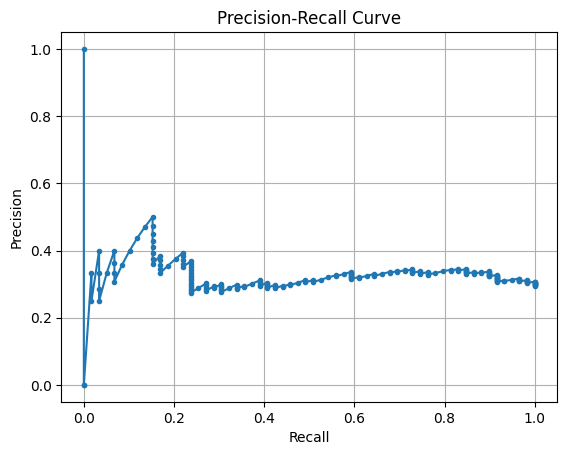

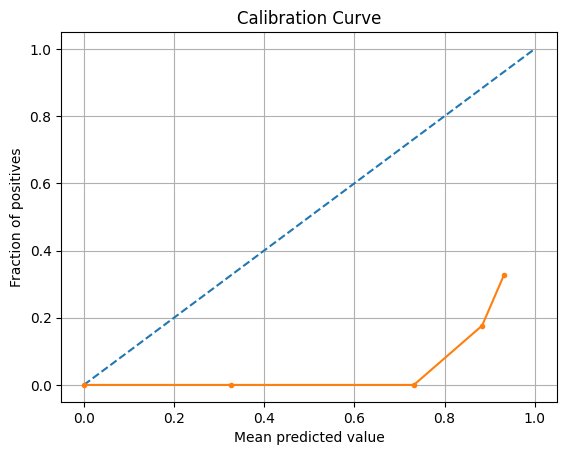


Model:  LogisticRegression
Best params:  {}
Best score:  0.45277534341573744
F1:  0.32061068702290074
Precision:  0.45652173913043476
Recall:  0.24705882352941178
Accuracy:  0.555
Negative predictive value:  0.58
Positive predictive value:  0.46
Cost:  95.25

F1 train:  0.4060721062618596
Precision train:  0.5783783783783784
Recall train:  0.3128654970760234
Accuracy train:  0.60875
Negative predictive value train:  0.62
Positive predictive value train:  0.58
Cost train:  332.5
              precision    recall  f1-score   support

           0       0.58      0.78      0.67       115
           1       0.46      0.25      0.32        85

    accuracy                           0.56       200
   macro avg       0.52      0.51      0.49       200
weighted avg       0.53      0.56      0.52       200



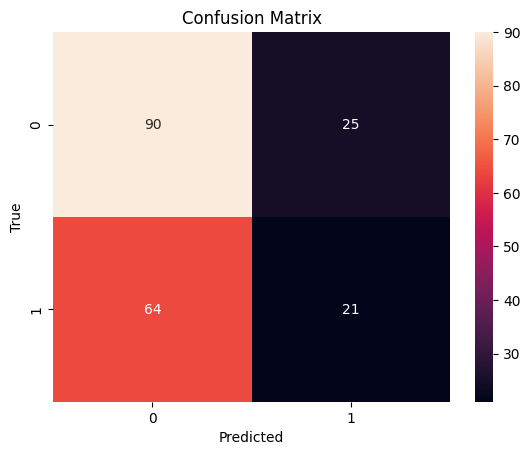

0.5589769820971867


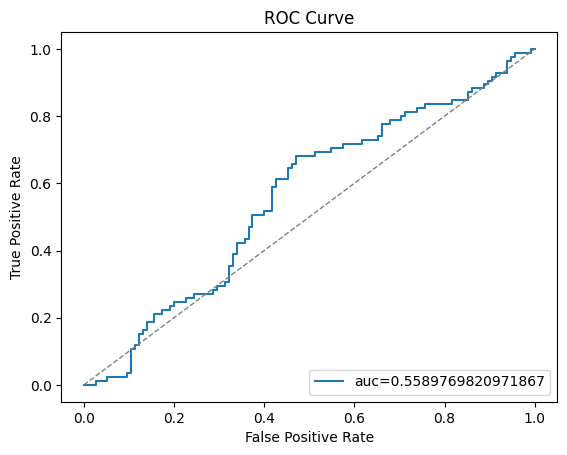

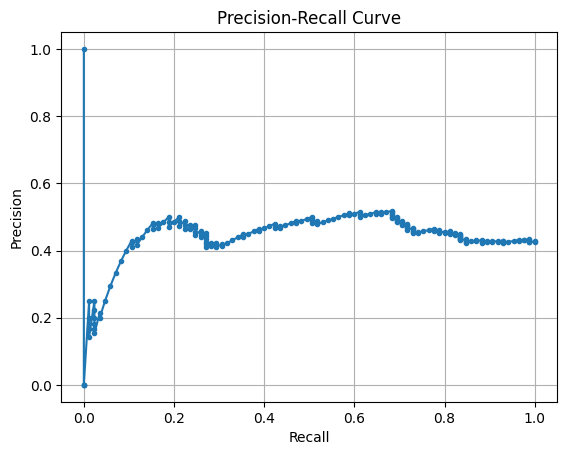

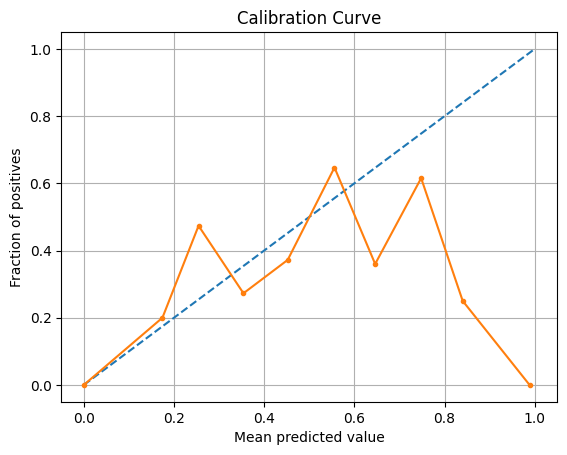

Best params:  {}
Best score:  0.4822281223310972
F1:  0.319327731092437
Precision:  0.5588235294117647
Recall:  0.2235294117647059
Accuracy:  0.595
Negative predictive value:  0.6
Positive predictive value:  0.56
Cost:  84.75

F1 train:  0.2760084925690021
Precision train:  0.5038759689922481
Recall train:  0.19005847953216373
Accuracy train:  0.57375
Negative predictive value train:  0.59
Positive predictive value train:  0.5
Cost train:  357.0
              precision    recall  f1-score   support

           0       0.60      0.87      0.71       115
           1       0.56      0.22      0.32        85

    accuracy                           0.59       200
   macro avg       0.58      0.55      0.52       200
weighted avg       0.58      0.59      0.54       200



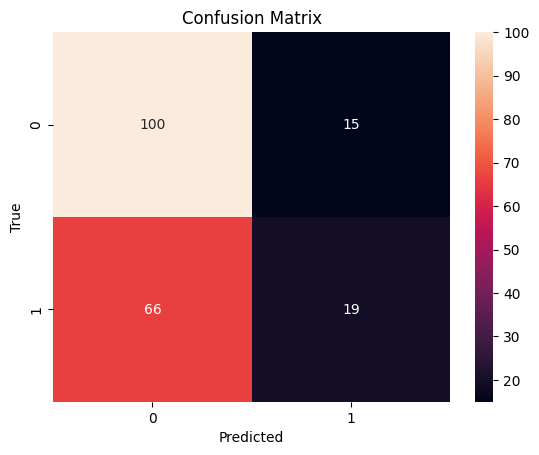

0.6159590792838875


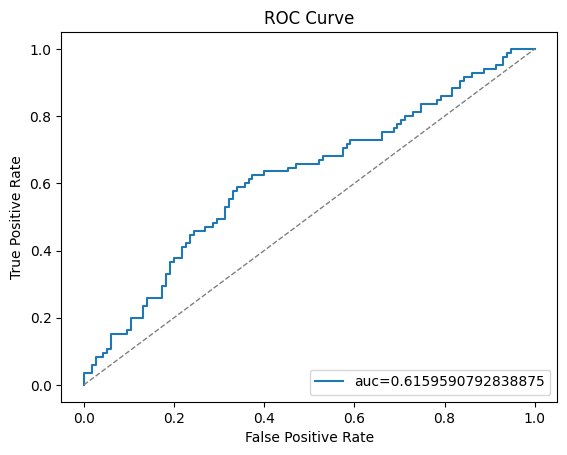

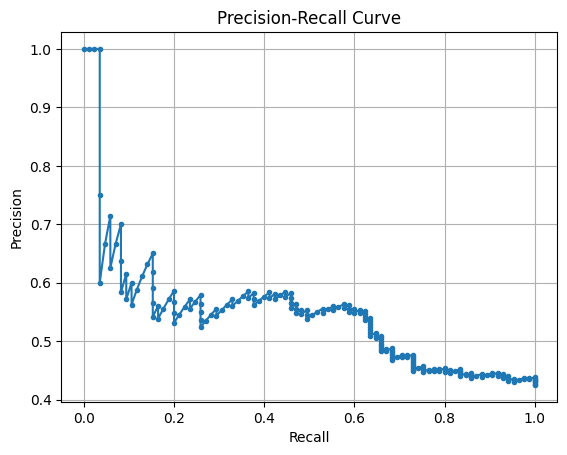

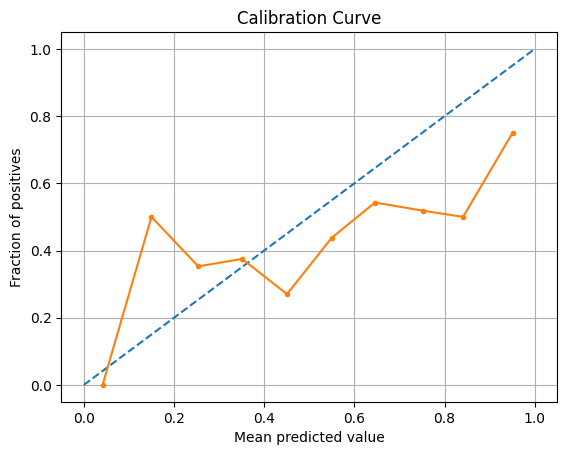

Best params:  {}
Best score:  0.5745117963120137
F1:  0.32894736842105265
Precision:  0.29411764705882354
Recall:  0.373134328358209
Accuracy:  0.49
Negative predictive value:  0.63
Positive predictive value:  0.29
Cost:  117.0

F1 train:  0.6512915129151291
Precision train:  0.6371841155234657
Recall train:  0.6660377358490566
Accuracy train:  0.6423841059602649
Negative predictive value train:  0.65
Positive predictive value train:  0.64
Cost train:  428.25
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       133
           1       0.29      0.37      0.33        67

    accuracy                           0.49       200
   macro avg       0.46      0.46      0.46       200
weighted avg       0.52      0.49      0.50       200



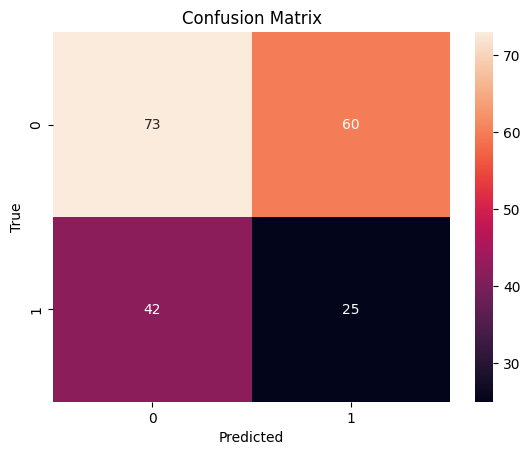

0.4501178318931658


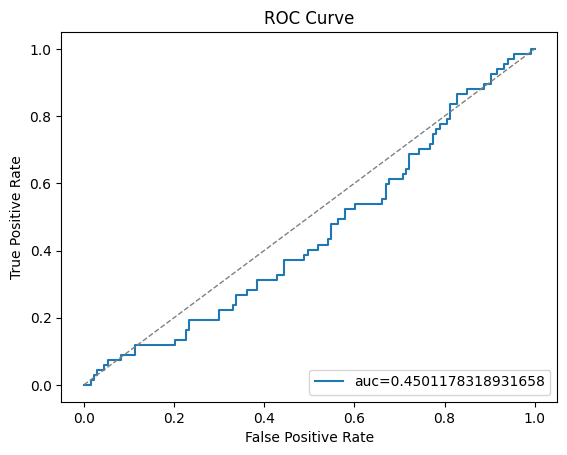

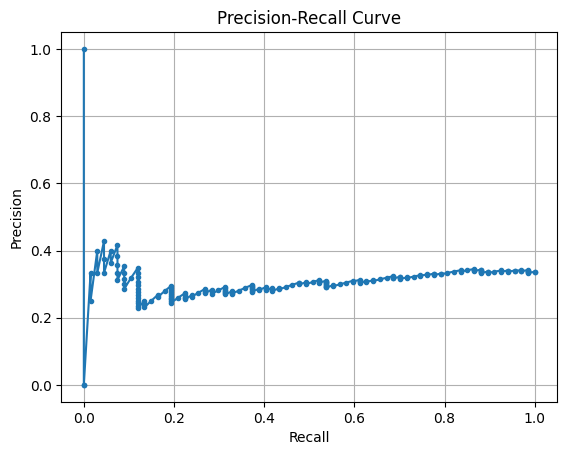

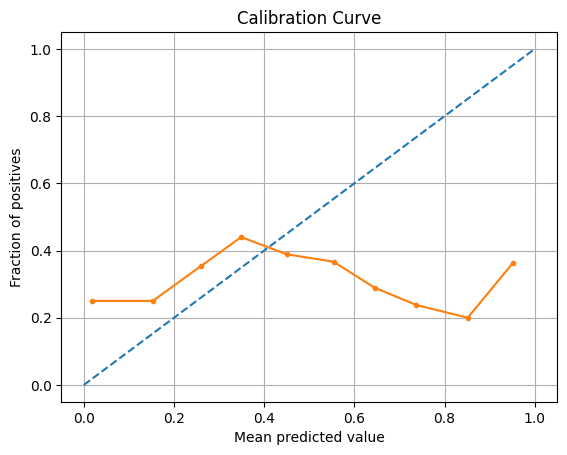

Best params:  {}
Best score:  0.5620896801967852
F1:  0.4431137724550898
Precision:  0.37
Recall:  0.5522388059701493
Accuracy:  0.535
Negative predictive value:  0.7
Positive predictive value:  0.37
Cost:  108.75

F1 train:  0.5848375451263539
Precision train:  0.5644599303135889
Recall train:  0.6067415730337079
Accuracy train:  0.5664467483506126
Negative predictive value train:  0.57
Positive predictive value train:  0.56
Cost train:  522.5
              precision    recall  f1-score   support

           0       0.70      0.53      0.60       133
           1       0.37      0.55      0.44        67

    accuracy                           0.54       200
   macro avg       0.53      0.54      0.52       200
weighted avg       0.59      0.54      0.55       200



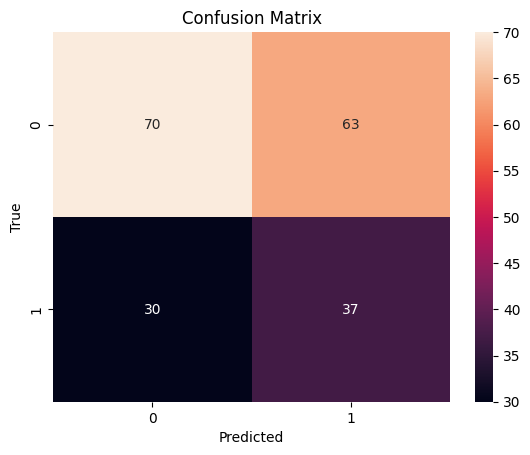

0.528335764785097


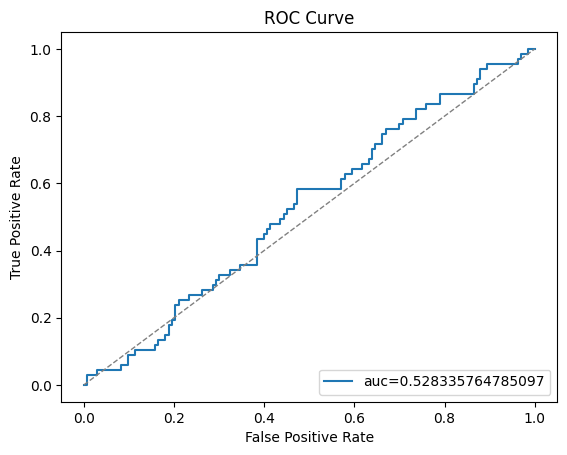

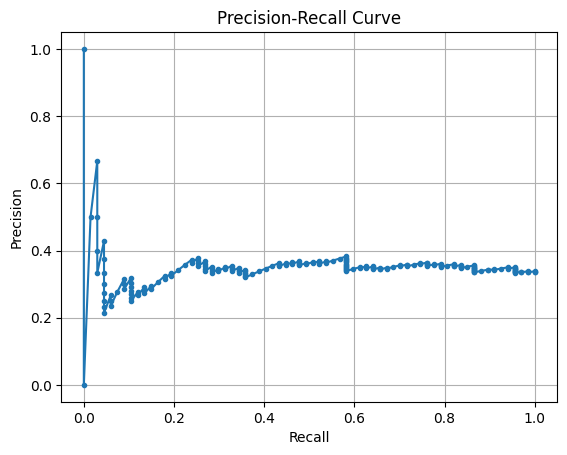

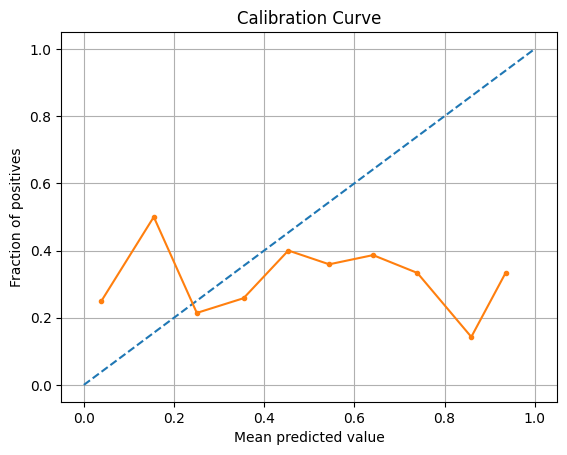

Best params:  {}
Best score:  0.5935321353306964
F1:  0.31111111111111117
Precision:  0.27631578947368424
Recall:  0.3559322033898305
Accuracy:  0.535
Negative predictive value:  0.69
Positive predictive value:  0.28
Cost:  106.75

F1 train:  0.6608996539792387
Precision train:  0.6507666098807495
Recall train:  0.671353251318102
Accuracy train:  0.654625550660793
Negative predictive value train:  0.66
Positive predictive value train:  0.65
Cost train:  443.25
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       141
           1       0.28      0.36      0.31        59

    accuracy                           0.54       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.57      0.54      0.55       200



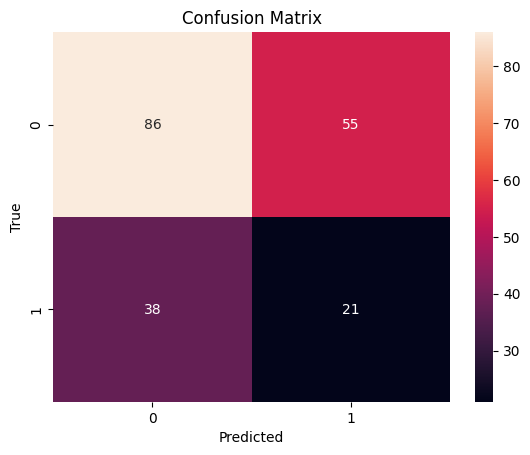

0.45666546459911045


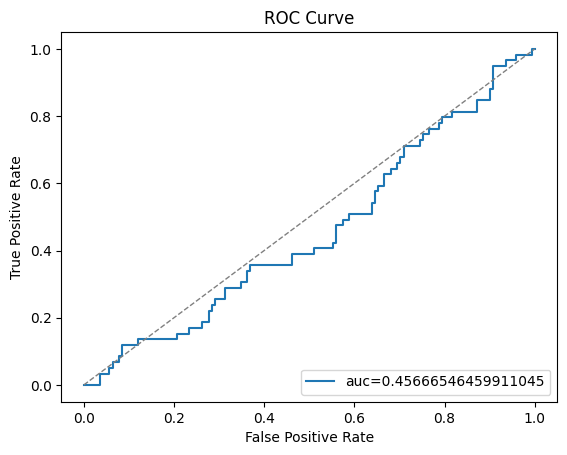

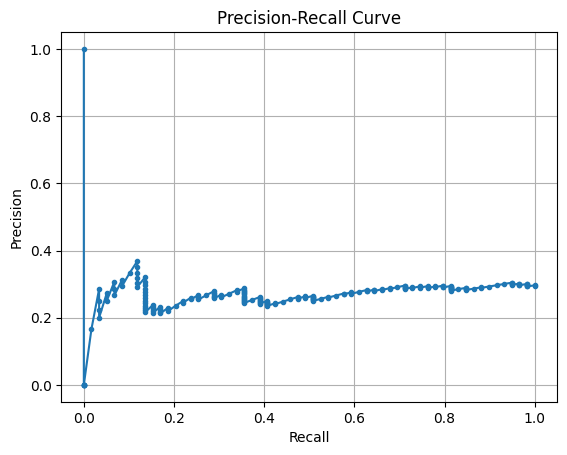

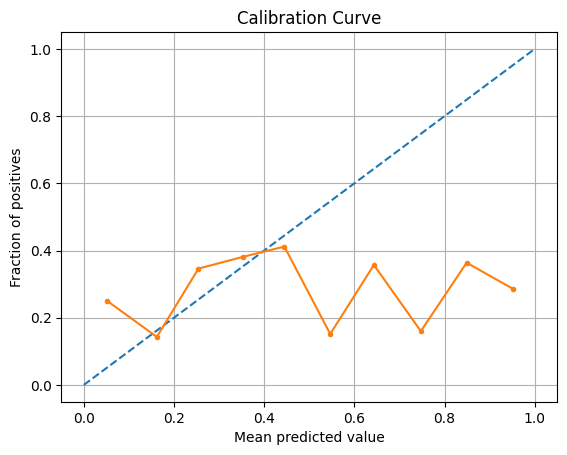

Best params:  {}
Best score:  0.5719764367165491
F1:  0.40506329113924056
Precision:  0.32323232323232326
Recall:  0.5423728813559322
Accuracy:  0.53
Negative predictive value:  0.73
Positive predictive value:  0.32
Cost:  110.75

F1 train:  0.6272944932162808
Precision train:  0.5874439461883408
Recall train:  0.672945205479452
Accuracy train:  0.5939130434782609
Negative predictive value train:  0.6
Positive predictive value train:  0.59
Cost train:  536.0
              precision    recall  f1-score   support

           0       0.73      0.52      0.61       141
           1       0.32      0.54      0.41        59

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.51       200
weighted avg       0.61      0.53      0.55       200



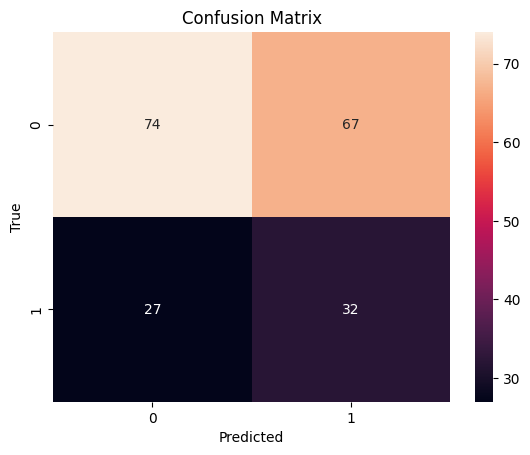

0.5308330328164443


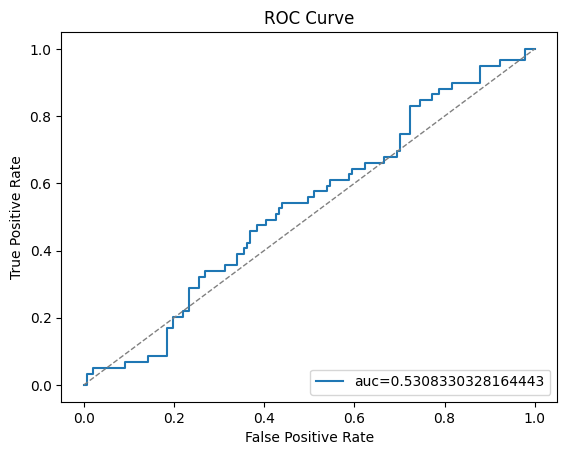

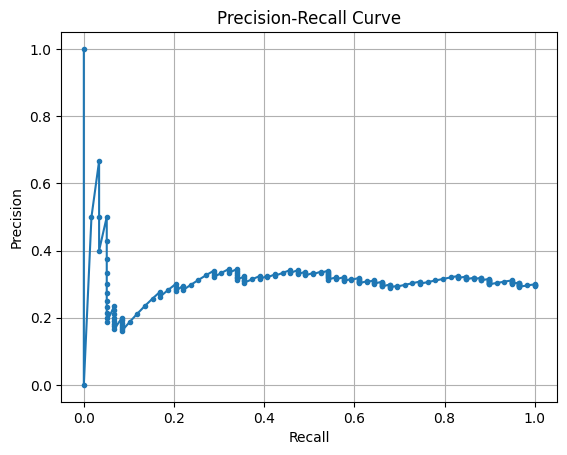

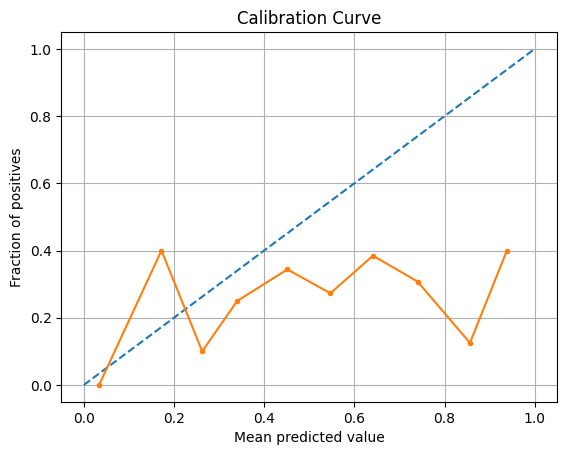


Model:  SVC
Best params:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
Best score:  0.6666666666666667
F1:  0.0449438202247191
Precision:  0.5
Recall:  0.023529411764705882
Accuracy:  0.575
Negative predictive value:  0.58
Positive predictive value:  0.5
Cost:  85.5

F1 train:  0.05665722379603399
Precision train:  0.9090909090909091
Recall train:  0.029239766081871343
Accuracy train:  0.58375
Negative predictive value train:  0.58
Positive predictive value train:  0.91
Cost train:  333.25
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       115
           1       0.50      0.02      0.04        85

    accuracy                           0.57       200
   macro avg       0.54      0.50      0.39       200
weighted avg       0.54      0.57      0.44       200



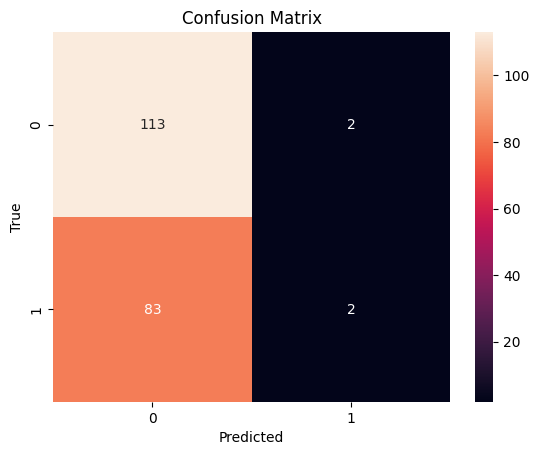

0.48705882352941177


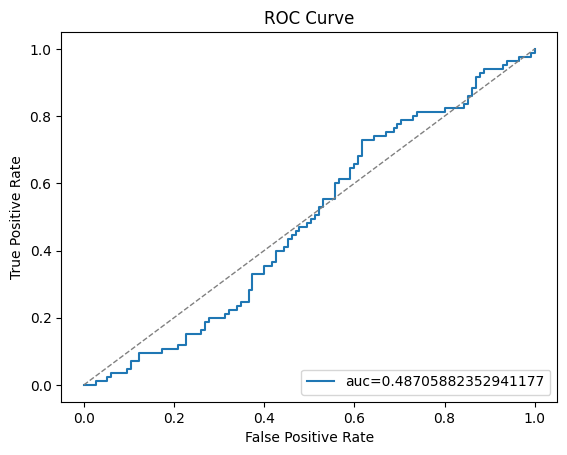

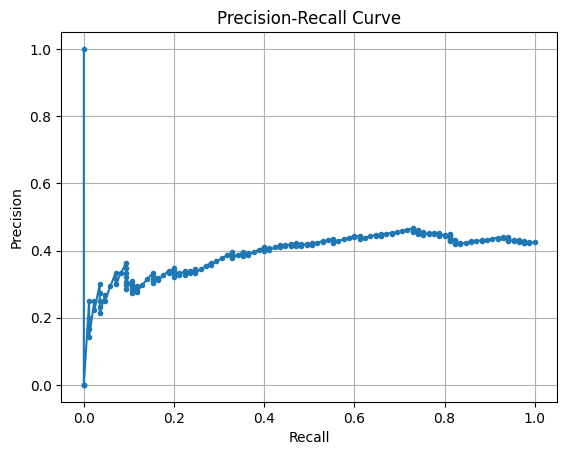

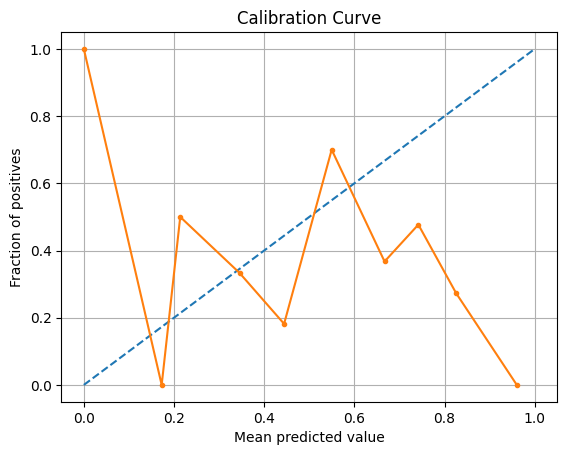

Best params:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.5233766233766233
F1:  0.125
Precision:  0.5454545454545454
Recall:  0.07058823529411765
Accuracy:  0.58
Negative predictive value:  0.58
Positive predictive value:  0.55
Cost:  85.25

F1 train:  0.18508997429305912
Precision train:  0.7659574468085106
Recall train:  0.10526315789473684
Accuracy train:  0.60375
Negative predictive value train:  0.59
Positive predictive value train:  0.77
Cost train:  319.75
              precision    recall  f1-score   support

           0       0.58      0.96      0.72       115
           1       0.55      0.07      0.12        85

    accuracy                           0.58       200
   macro avg       0.56      0.51      0.42       200
weighted avg       0.57      0.58      0.47       200



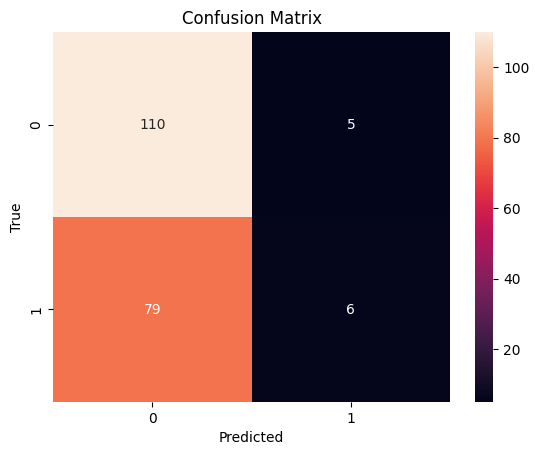

0.5794373401534527


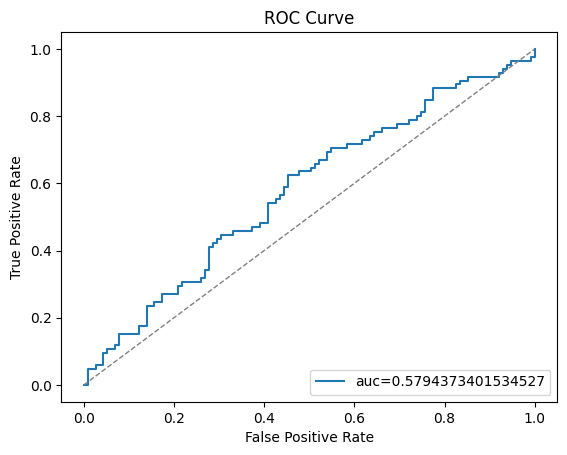

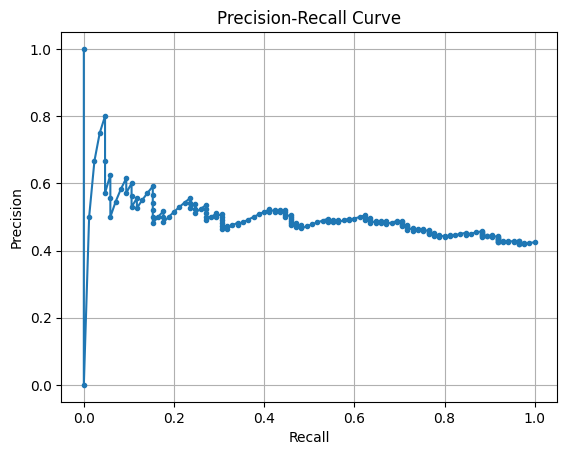

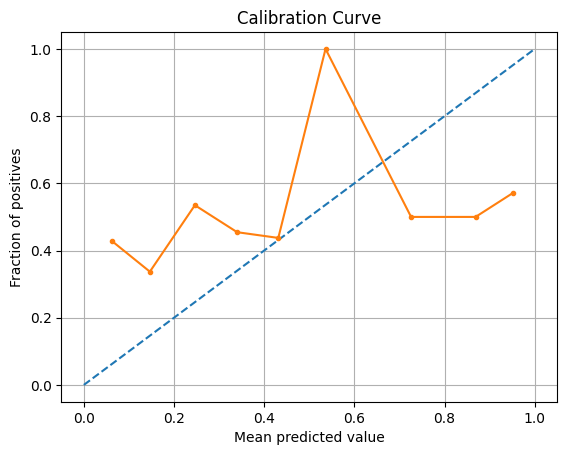

Best params:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.6762826664385465
F1:  0.3458646616541354
Precision:  0.3484848484848485
Recall:  0.34328358208955223
Accuracy:  0.565
Negative predictive value:  0.67
Positive predictive value:  0.35
Cost:  97.75

F1 train:  0.9841269841269841
Precision train:  0.9741219963031423
Recall train:  0.9943396226415094
Accuracy train:  0.9839167455061495
Negative predictive value train:  0.99
Positive predictive value train:  0.97
Cost train:  20.5
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       133
           1       0.35      0.34      0.35        67

    accuracy                           0.56       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.56      0.56      0.56       200



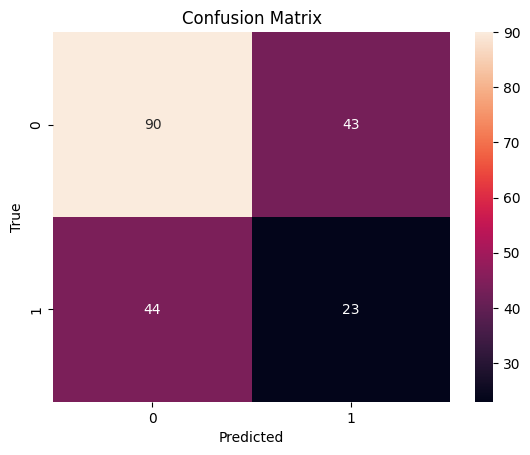

0.47082257883514755


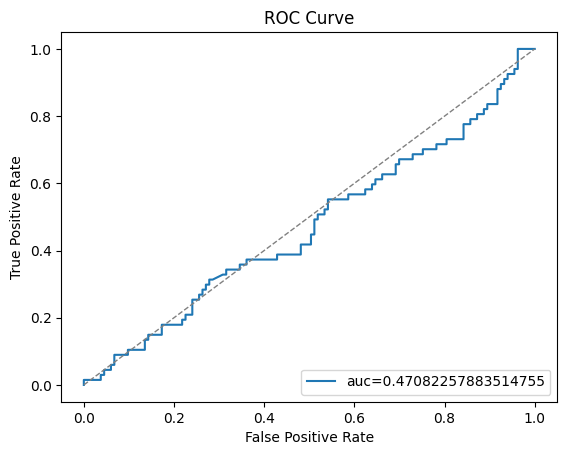

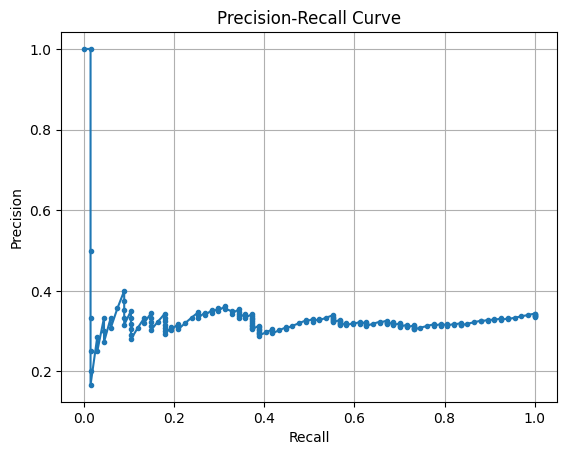

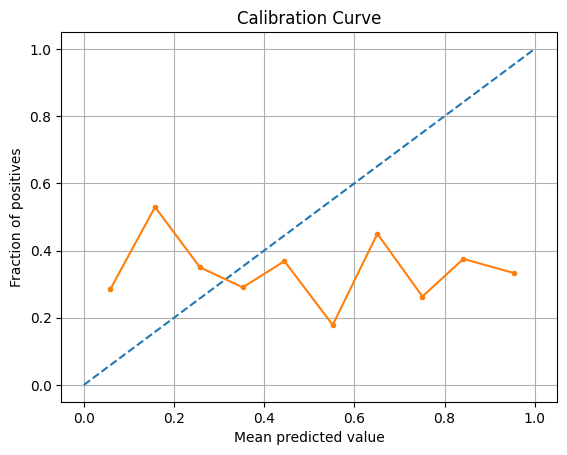

Best params:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.6476056235714803
F1:  0.48750000000000004
Precision:  0.41935483870967744
Recall:  0.582089552238806
Accuracy:  0.59
Negative predictive value:  0.74
Positive predictive value:  0.42
Cost:  95.5

F1 train:  0.8376511226252159
Precision train:  0.7772435897435898
Recall train:  0.9082397003745318
Accuracy train:  0.822808671065033
Negative predictive value train:  0.89
Positive predictive value train:  0.78
Cost train:  222.75
              precision    recall  f1-score   support

           0       0.74      0.59      0.66       133
           1       0.42      0.58      0.49        67

    accuracy                           0.59       200
   macro avg       0.58      0.59      0.57       200
weighted avg       0.63      0.59      0.60       200



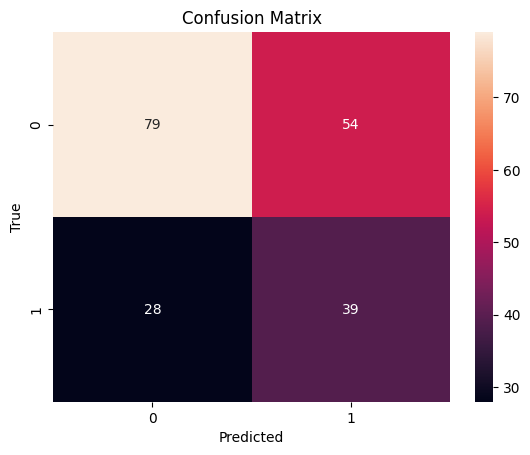

0.5988104589832791


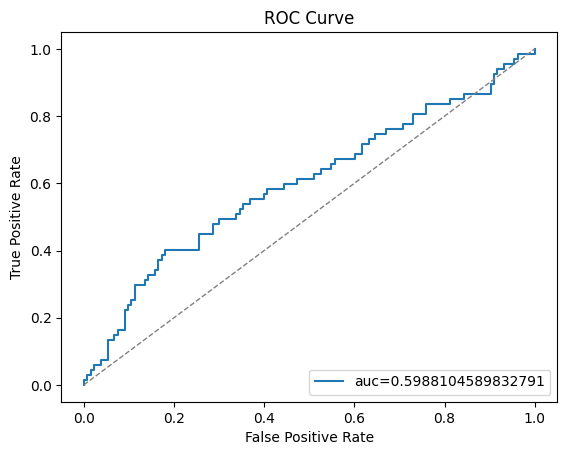

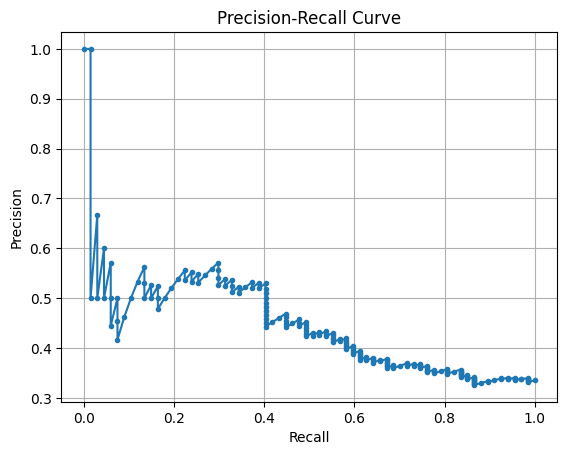

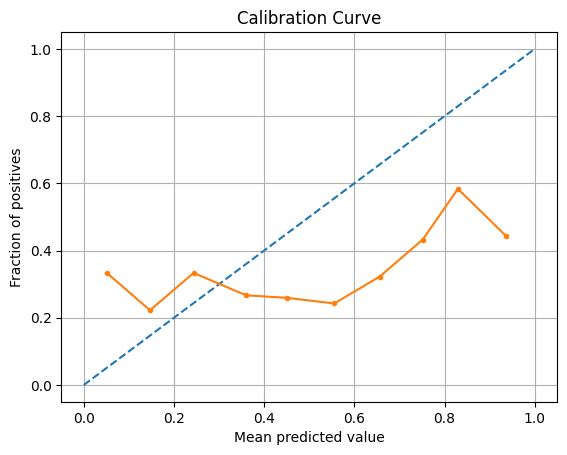

Best params:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.7067357162984161
F1:  0.3548387096774193
Precision:  0.3384615384615385
Recall:  0.3728813559322034
Accuracy:  0.6
Negative predictive value:  0.73
Positive predictive value:  0.34
Cost:  90.75

F1 train:  0.980836236933798
Precision train:  0.9723661485319517
Recall train:  0.9894551845342706
Accuracy train:  0.9806167400881057
Negative predictive value train:  0.99
Positive predictive value train:  0.97
Cost train:  26.0
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       141
           1       0.34      0.37      0.35        59

    accuracy                           0.60       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.61      0.60      0.61       200



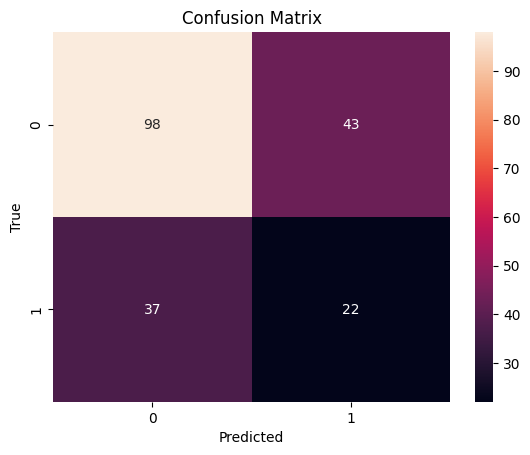

0.5189325640100974


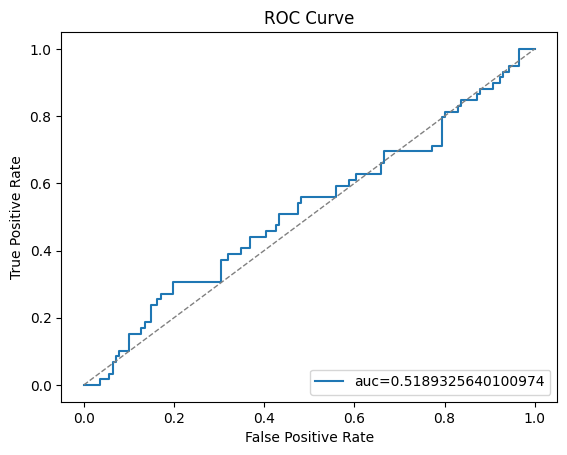

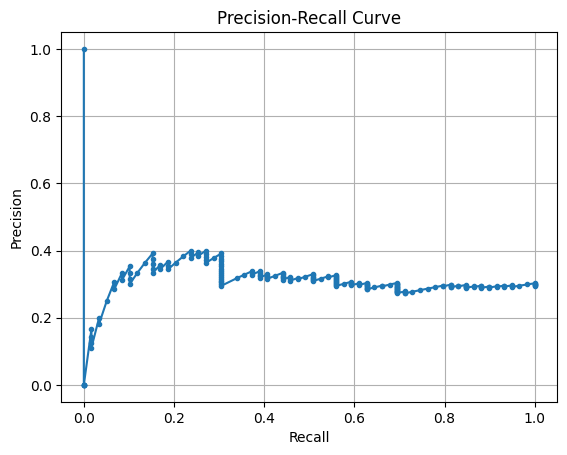

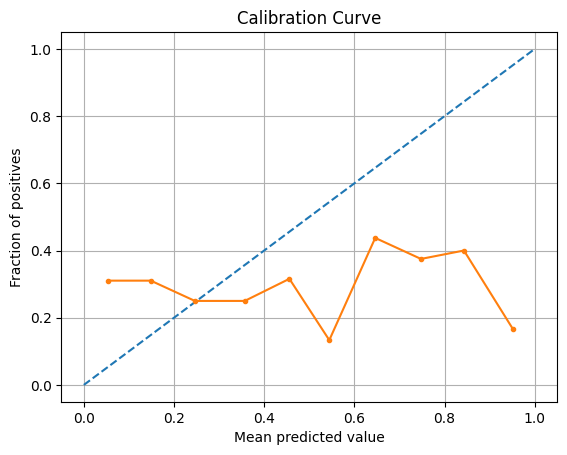

Best params:  {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.6729191296933232
F1:  0.43537414965986393
Precision:  0.36363636363636365
Recall:  0.5423728813559322
Accuracy:  0.585
Negative predictive value:  0.76
Positive predictive value:  0.36
Cost:  97.0

F1 train:  0.8997594226142743
Precision train:  0.8461538461538461
Recall train:  0.9606164383561644
Accuracy train:  0.8913043478260869
Negative predictive value train:  0.95
Positive predictive value train:  0.85
Cost train:  150.5
              precision    recall  f1-score   support

           0       0.76      0.60      0.67       141
           1       0.36      0.54      0.44        59

    accuracy                           0.58       200
   macro avg       0.56      0.57      0.55       200
weighted avg       0.64      0.58      0.60       200



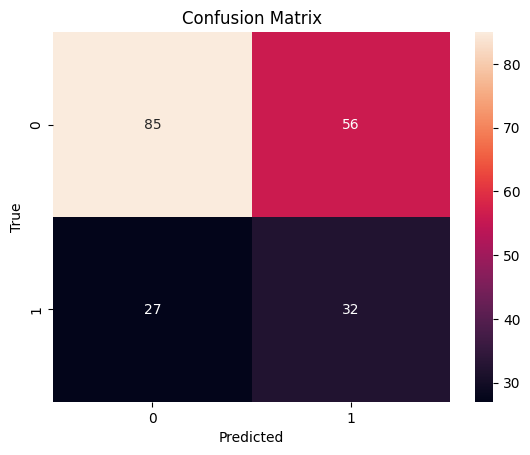

0.5602836879432624


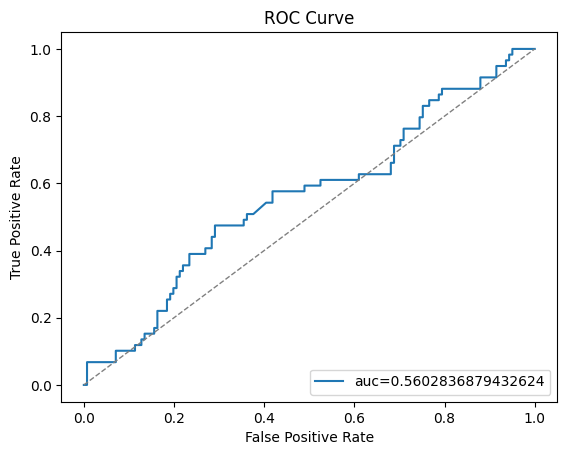

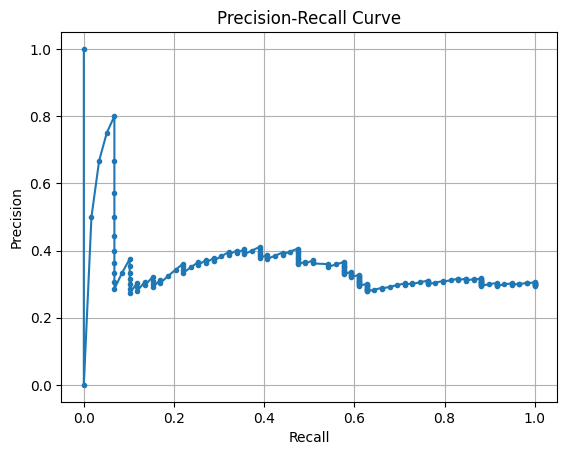

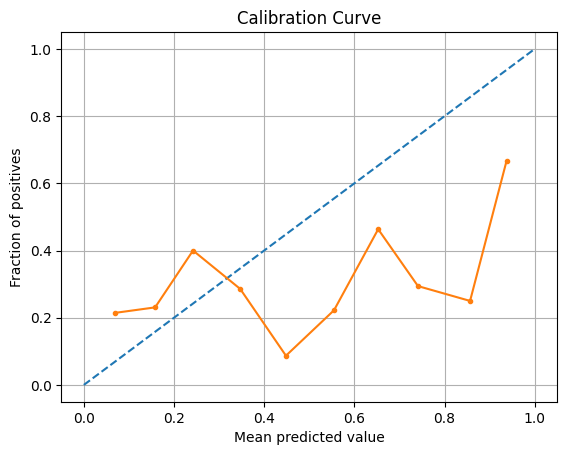


Model:  MLPClassifier
Best params:  {'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'solver': 'sgd'}
Best score:  0.7
F1:  0.04301075268817204
Precision:  0.25
Recall:  0.023529411764705882
Accuracy:  0.555
Negative predictive value:  0.57
Positive predictive value:  0.25
Cost:  90.5

F1 train:  0.05027932960893855
Precision train:  0.5625
Recall train:  0.02631578947368421
Accuracy train:  0.575
Negative predictive value train:  0.58
Positive predictive value train:  0.56
Cost train:  341.75
              precision    recall  f1-score   support

           0       0.57      0.95      0.71       115
           1       0.25      0.02      0.04        85

    accuracy                           0.56       200
   macro avg       0.41      0.49      0.38       200
weighted avg       0.43      0.56      0.43       200



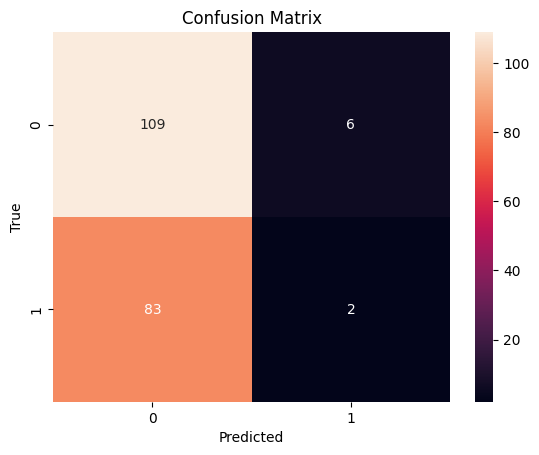

0.4426598465473145


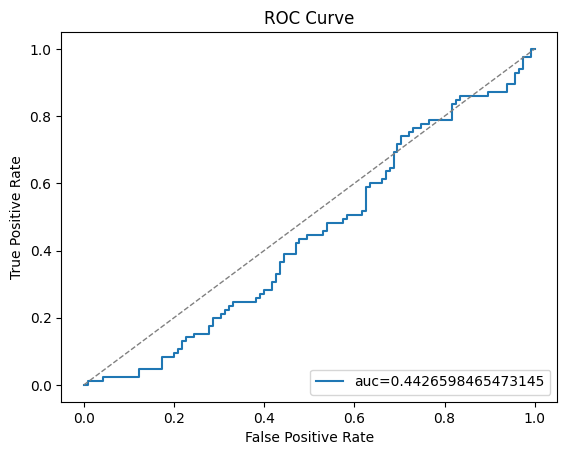

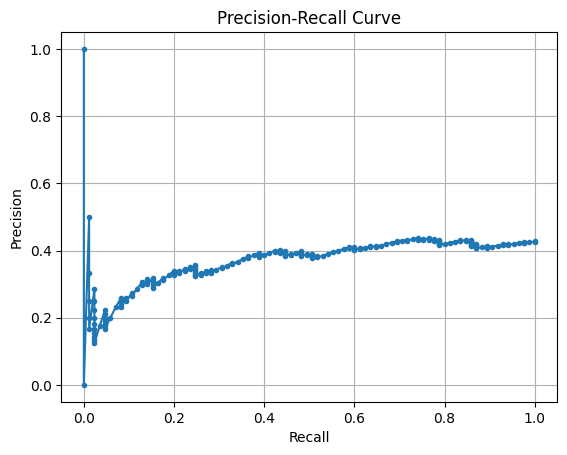

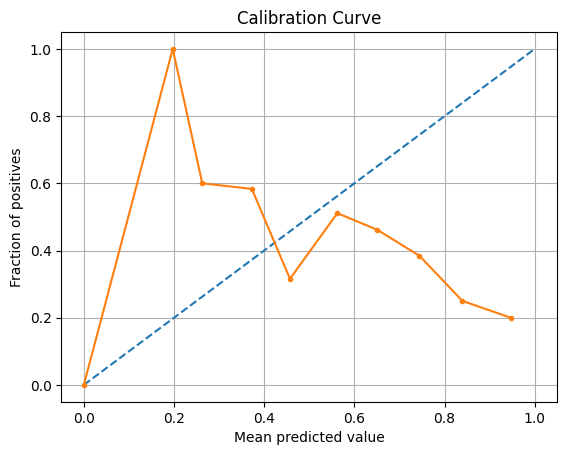

Best params:  {'activation': 'tanh', 'hidden_layer_sizes': (3, 5), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score:  0.7
F1:  0.08421052631578947
Precision:  0.4
Recall:  0.047058823529411764
Accuracy:  0.565
Negative predictive value:  0.57
Positive predictive value:  0.4
Cost:  88.5

F1 train:  0.07588075880758807
Precision train:  0.5185185185185185
Recall train:  0.04093567251461988
Accuracy train:  0.57375
Negative predictive value train:  0.58
Positive predictive value train:  0.52
Cost train:  344.25
              precision    recall  f1-score   support

           0       0.57      0.95      0.71       115
           1       0.40      0.05      0.08        85

    accuracy                           0.56       200
   macro avg       0.49      0.50      0.40       200
weighted avg       0.50      0.56      0.45       200



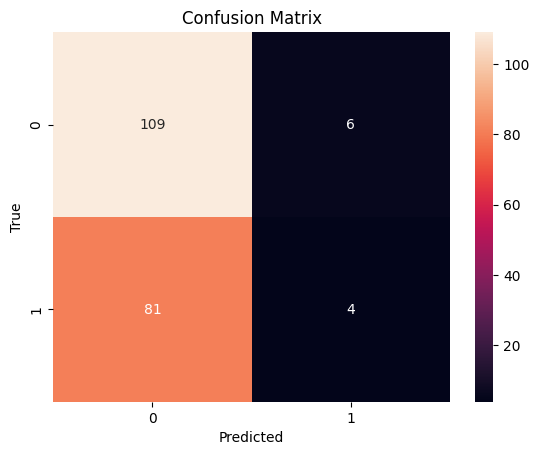

0.5426086956521738


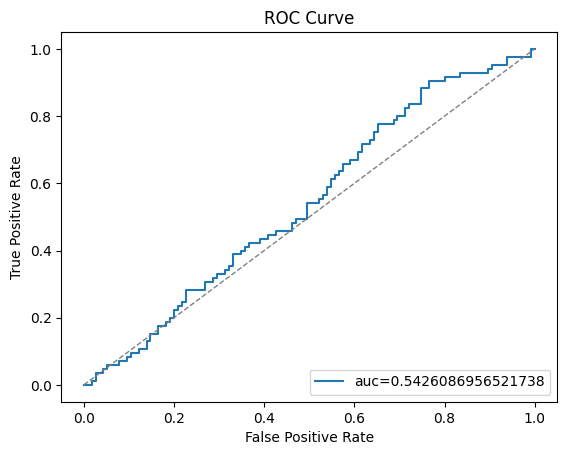

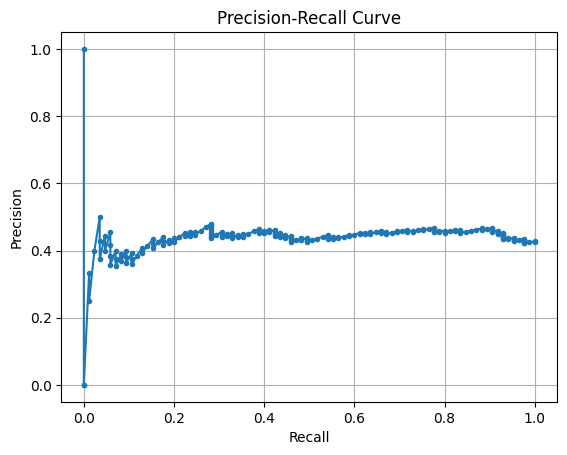

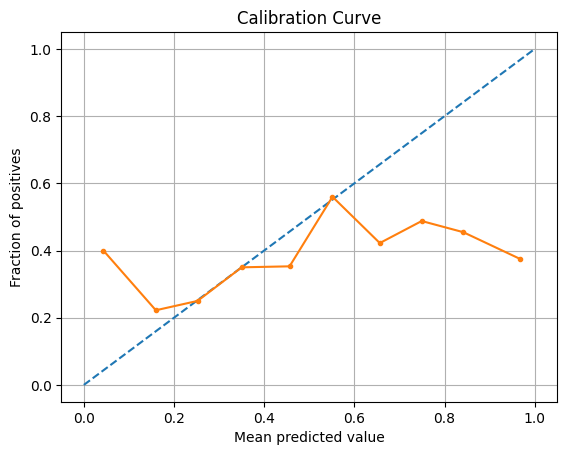

Best params:  {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'solver': 'adam'}
Best score:  0.6901661918328585
F1:  0.3733333333333333
Precision:  0.3373493975903614
Recall:  0.417910447761194
Accuracy:  0.53
Negative predictive value:  0.67
Positive predictive value:  0.34
Cost:  107.75

F1 train:  0.9962406015037594
Precision train:  0.9925093632958801
Recall train:  1.0
Accuracy train:  0.9962157048249763
Negative predictive value train:  1.0
Positive predictive value train:  0.99
Cost train:  5.0
              precision    recall  f1-score   support

           0       0.67      0.59      0.62       133
           1       0.34      0.42      0.37        67

    accuracy                           0.53       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.56      0.53      0.54       200



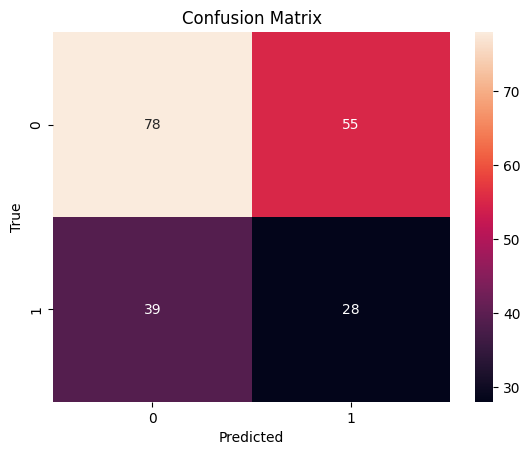

0.504881607002581


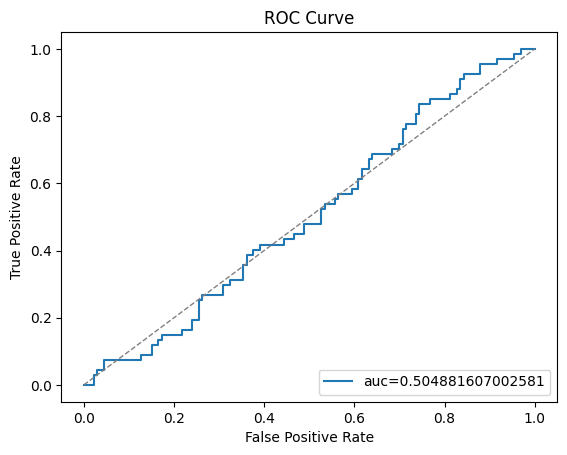

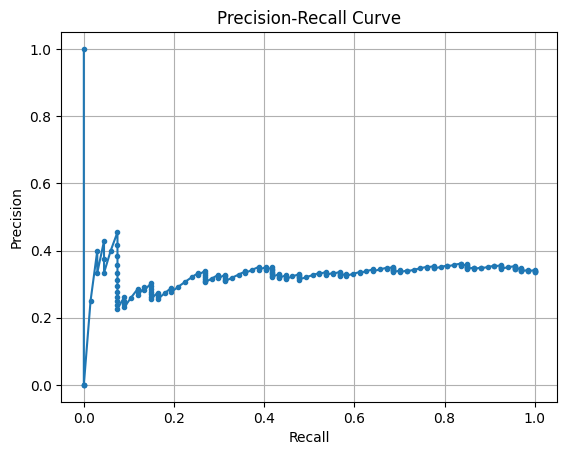

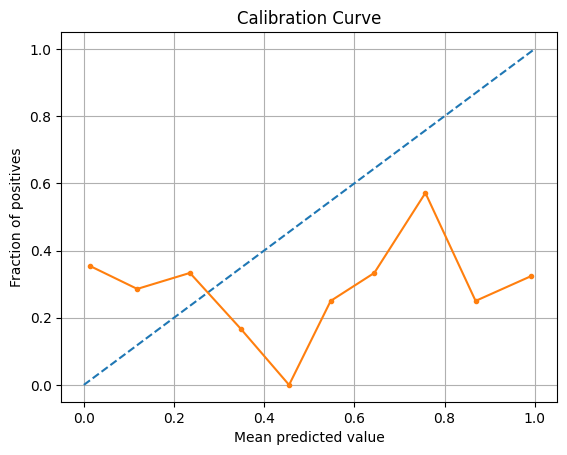

Best params:  {'activation': 'tanh', 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Best score:  0.6668636650681823
F1:  0.4413793103448276
Precision:  0.41025641025641024
Recall:  0.47761194029850745
Accuracy:  0.595
Negative predictive value:  0.71
Positive predictive value:  0.41
Cost:  92.5

F1 train:  0.8987108655616944
Precision train:  0.8840579710144928
Recall train:  0.9138576779026217
Accuracy train:  0.8963242224316682
Negative predictive value train:  0.91
Positive predictive value train:  0.88
Cost train:  126.0
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       133
           1       0.41      0.48      0.44        67

    accuracy                           0.59       200
   macro avg       0.56      0.57      0.56       200
weighted avg       0.61      0.59      0.60       200



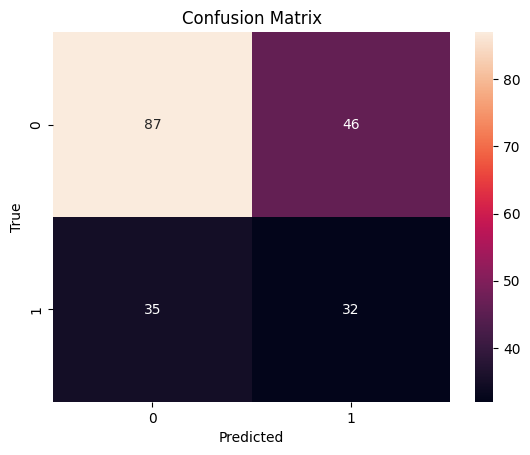

0.5587476153069241


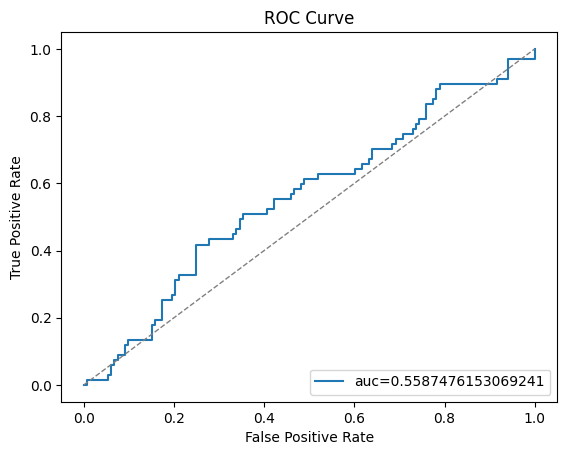

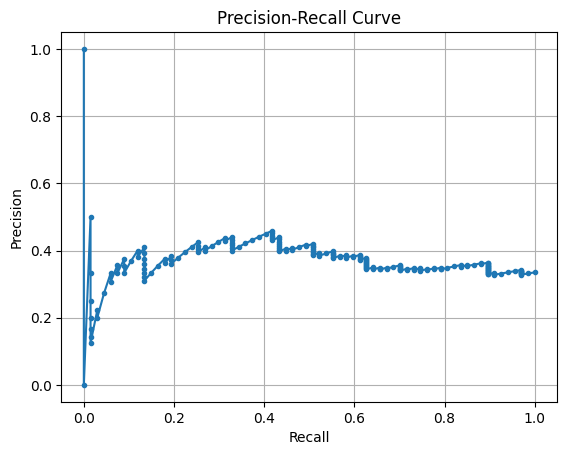

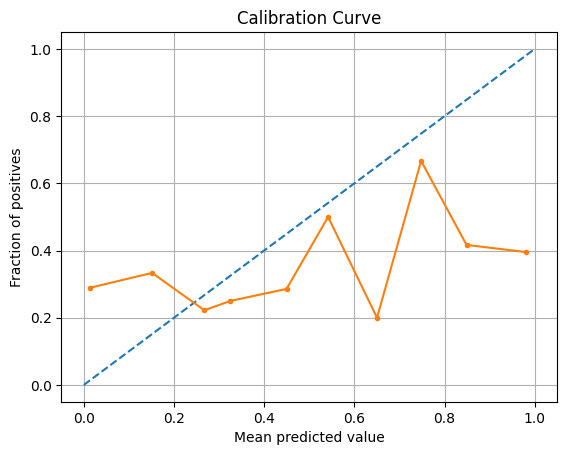

Best params:  {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score:  0.7206258490041079
F1:  0.32432432432432434
Precision:  0.34615384615384615
Recall:  0.3050847457627119
Accuracy:  0.625
Negative predictive value:  0.72
Positive predictive value:  0.35
Cost:  83.5

F1 train:  0.9982394366197184
Precision train:  1.0
Recall train:  0.9964850615114236
Accuracy train:  0.9982378854625551
Negative predictive value train:  1.0
Positive predictive value train:  1.0
Cost train:  2.0
              precision    recall  f1-score   support

           0       0.72      0.76      0.74       141
           1       0.35      0.31      0.32        59

    accuracy                           0.62       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.61      0.62      0.62       200



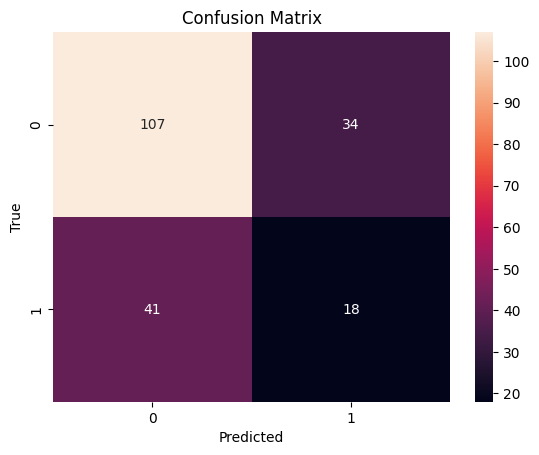

0.516528428897704


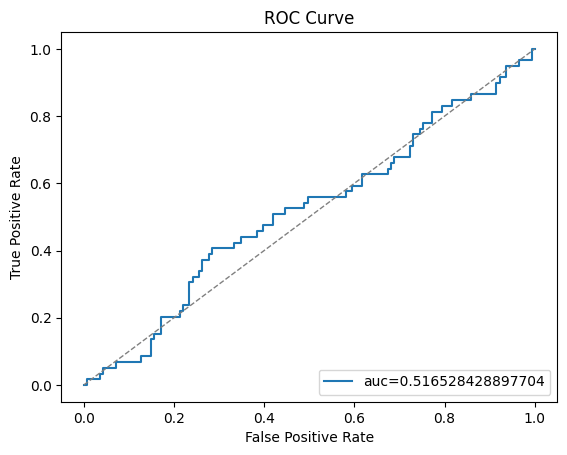

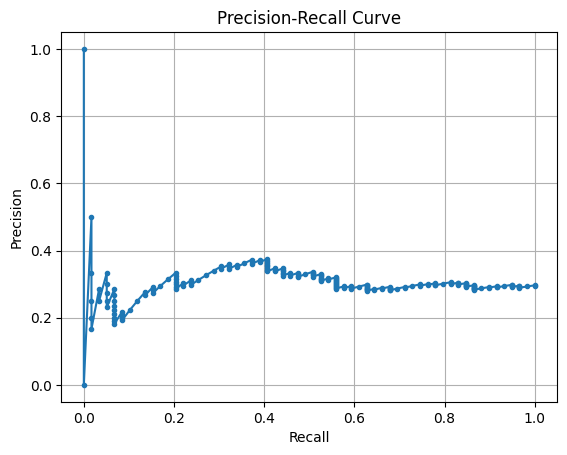

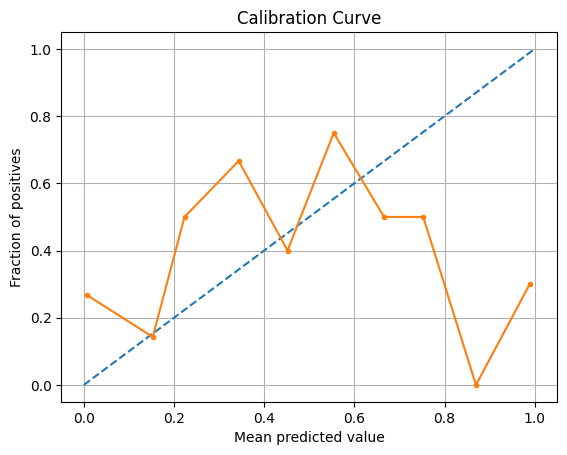

Best params:  {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'solver': 'adam'}
Best score:  0.7116295588058786
F1:  0.3529411764705882
Precision:  0.35
Recall:  0.3559322033898305
Accuracy:  0.615
Negative predictive value:  0.73
Positive predictive value:  0.35
Cost:  86.75

F1 train:  0.8986013986013986
Precision train:  0.9178571428571428
Recall train:  0.8801369863013698
Accuracy train:  0.8991304347826087
Negative predictive value train:  0.88
Positive predictive value train:  0.92
Cost train:  127.5
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       141
           1       0.35      0.36      0.35        59

    accuracy                           0.61       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.62      0.61      0.62       200



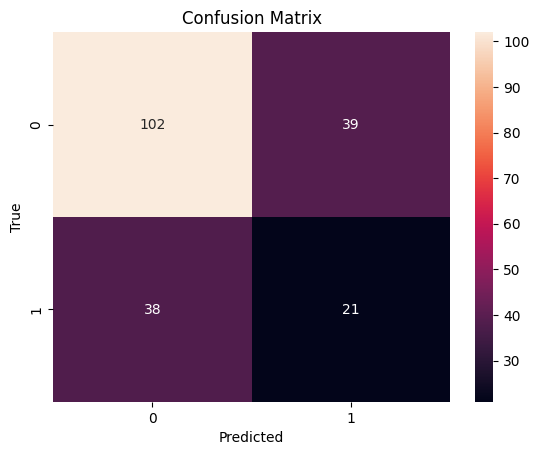

0.5248226950354611


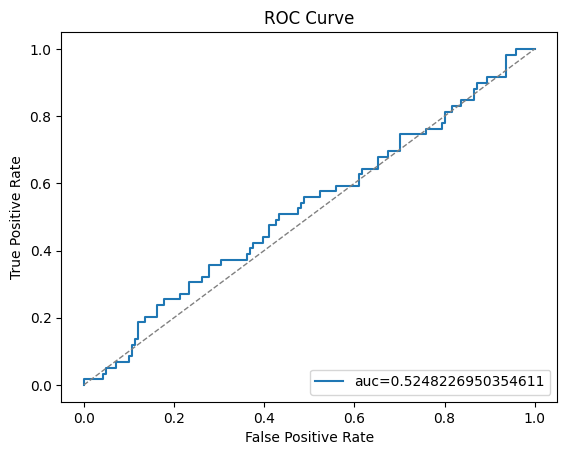

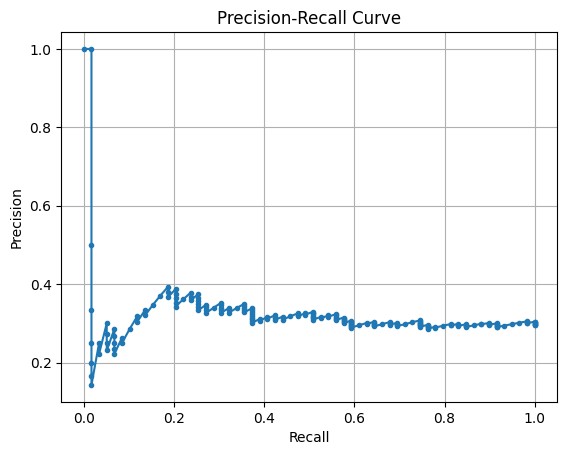

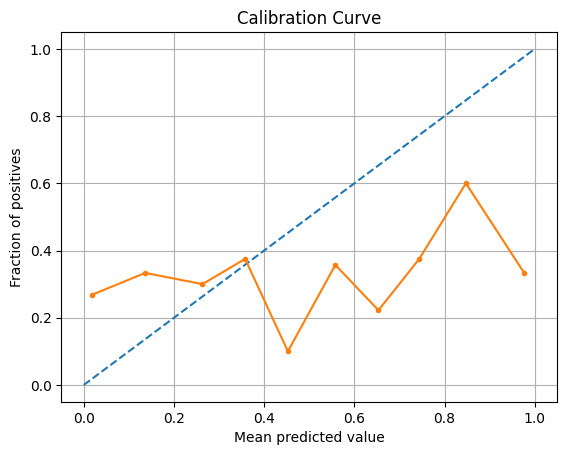


Model:  DecisionTreeClassifier
Best params:  {'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 3}
Best score:  0.5685425685425686
F1:  0.1320754716981132
Precision:  0.3333333333333333
Recall:  0.08235294117647059
Accuracy:  0.54
Negative predictive value:  0.56
Positive predictive value:  0.33
Cost:  95.5

F1 train:  0.16368286445012786
Precision train:  0.6530612244897959
Recall train:  0.0935672514619883
Accuracy train:  0.59125
Negative predictive value train:  0.59
Positive predictive value train:  0.65
Cost train:  331.25
              precision    recall  f1-score   support

           0       0.56      0.88      0.69       115
           1       0.33      0.08      0.13        85

    accuracy                           0.54       200
   macro avg       0.45      0.48      0.41       200
weighted avg       0.47      0.54      0.45       200



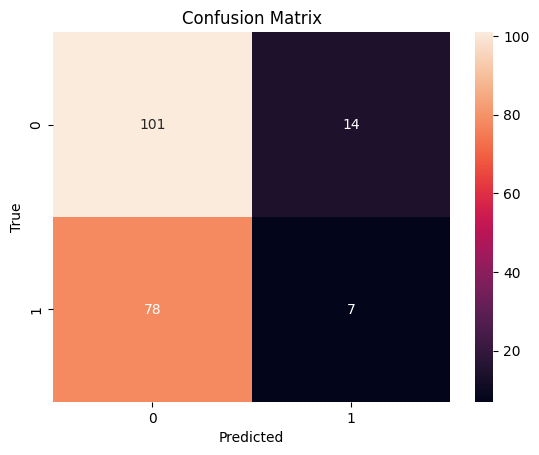

0.5046035805626599


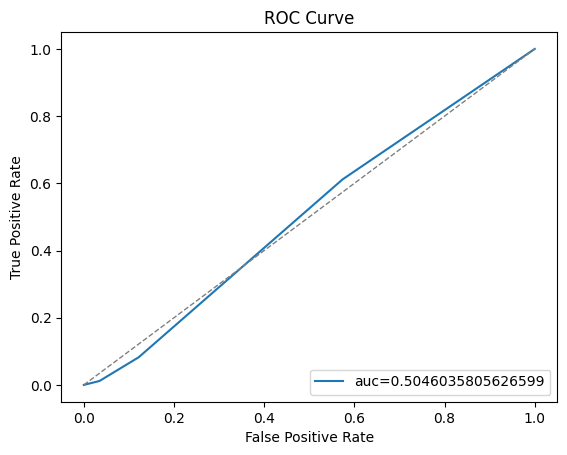

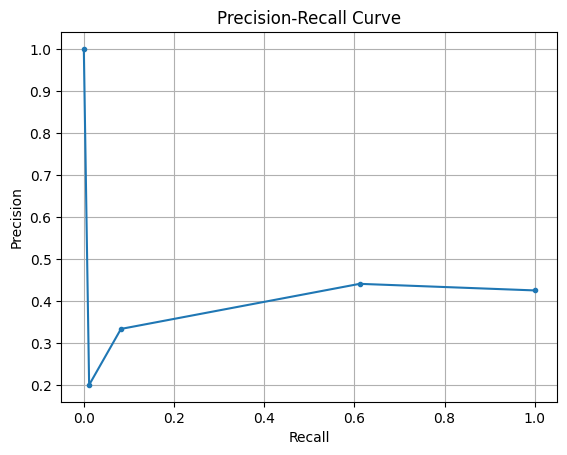

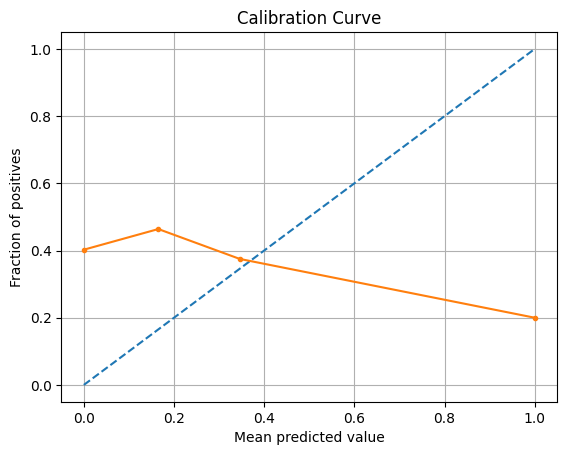

Best params:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3}
Best score:  0.4656979620059586
F1:  0.4258064516129032
Precision:  0.4714285714285714
Recall:  0.38823529411764707
Accuracy:  0.555
Negative predictive value:  0.6
Positive predictive value:  0.47
Cost:  98.25

F1 train:  0.7787307032590051
Precision train:  0.941908713692946
Recall train:  0.6637426900584795
Accuracy train:  0.83875
Negative predictive value train:  0.79
Positive predictive value train:  0.94
Cost train:  132.5
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       115
           1       0.47      0.39      0.43        85

    accuracy                           0.56       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.55      0.56      0.55       200



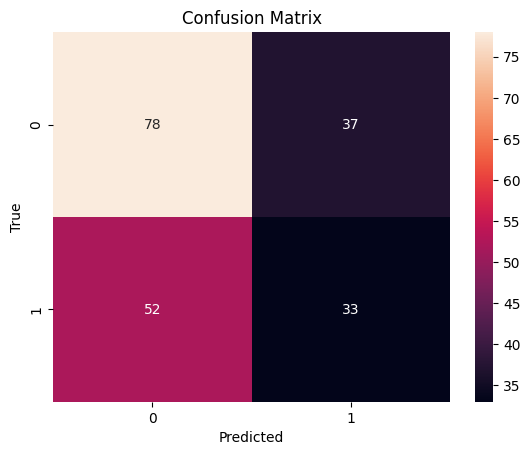

0.5204092071611254


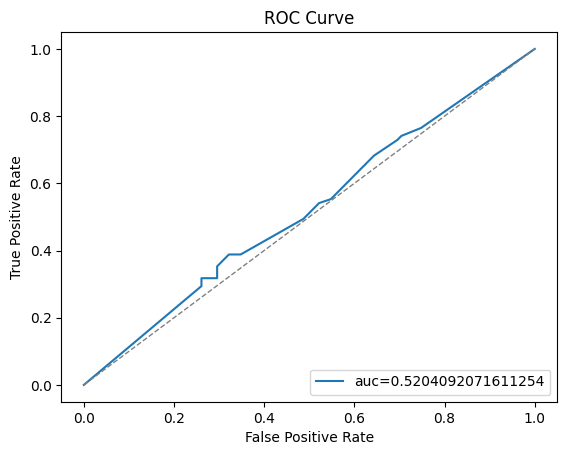

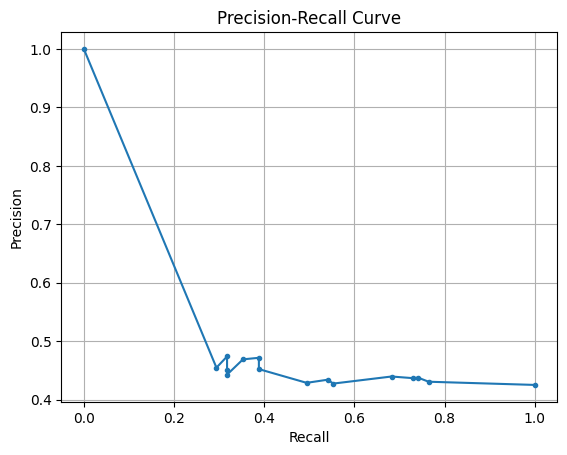

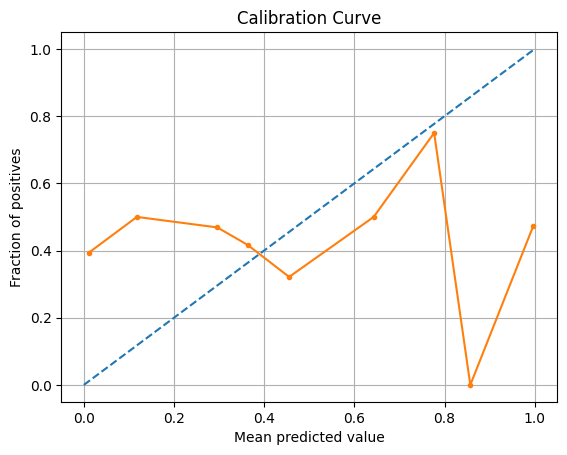

Best params:  {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 8}
Best score:  0.6514332980998996
F1:  0.3766233766233766
Precision:  0.3333333333333333
Recall:  0.43283582089552236
Accuracy:  0.52
Negative predictive value:  0.66
Positive predictive value:  0.33
Cost:  110.5

F1 train:  0.9305019305019305
Precision train:  0.9525691699604744
Recall train:  0.909433962264151
Accuracy train:  0.9318826868495743
Negative predictive value train:  0.91
Positive predictive value train:  0.95
Cost train:  78.0
              precision    recall  f1-score   support

           0       0.66      0.56      0.61       133
           1       0.33      0.43      0.38        67

    accuracy                           0.52       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.55      0.52      0.53       200



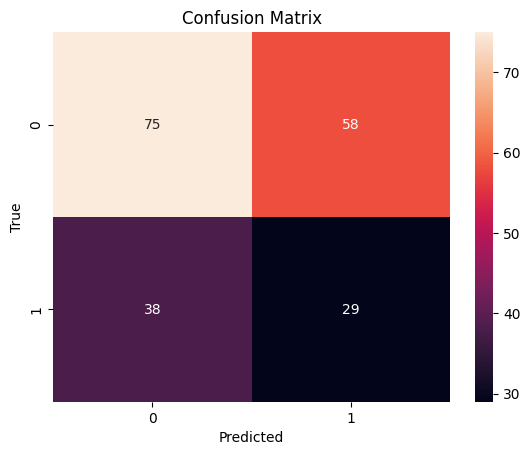

0.48832903153405904


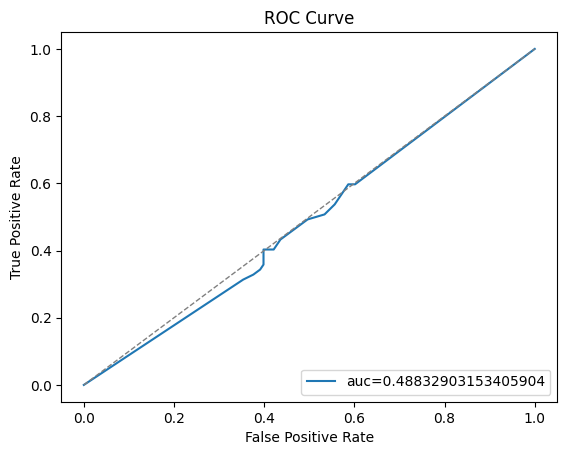

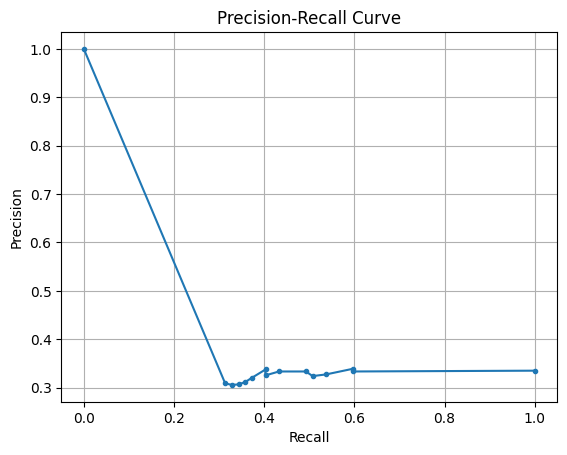

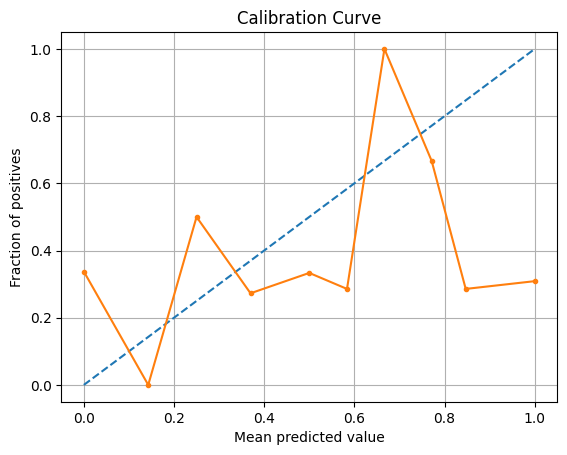

Best params:  {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 5}
Best score:  0.6405420548574707
F1:  0.3165467625899281
Precision:  0.3055555555555556
Recall:  0.3283582089552239
Accuracy:  0.525
Negative predictive value:  0.65
Positive predictive value:  0.31
Cost:  107.5

F1 train:  0.9590865842055184
Precision train:  0.9748549323017408
Recall train:  0.9438202247191011
Accuracy train:  0.9594721960414703
Negative predictive value train:  0.94
Positive predictive value train:  0.97
Cost train:  46.25
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       133
           1       0.31      0.33      0.32        67

    accuracy                           0.53       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.53      0.53      0.53       200



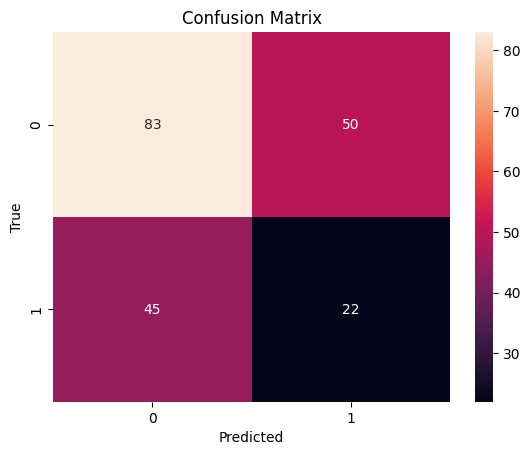

0.4642576590730557


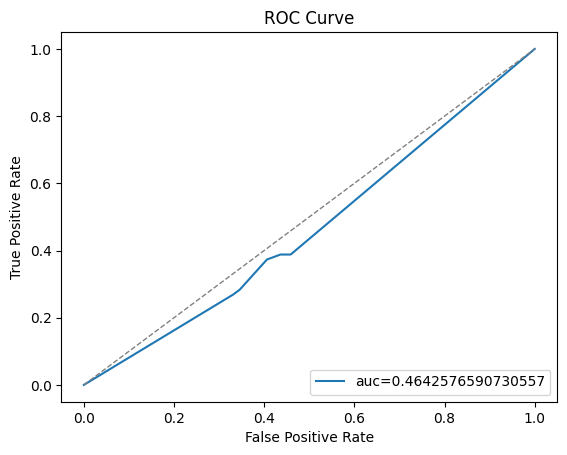

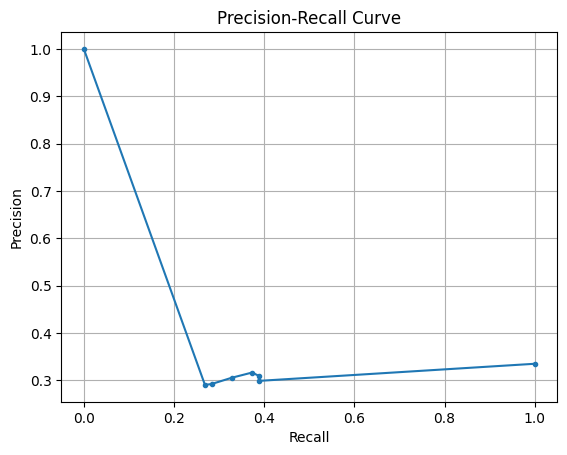

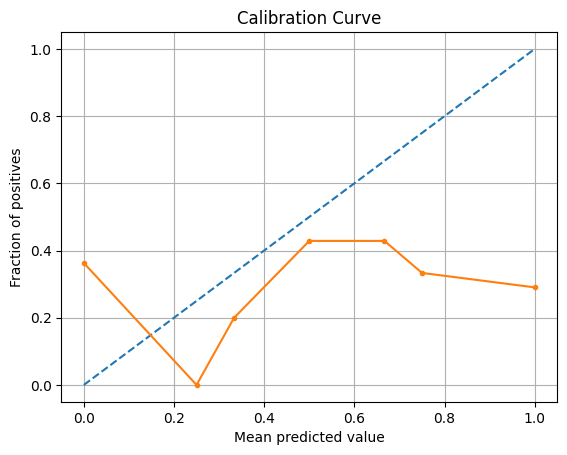

Best params:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5}
Best score:  0.651066780456582
F1:  0.34108527131782945
Precision:  0.3142857142857143
Recall:  0.3728813559322034
Accuracy:  0.575
Negative predictive value:  0.72
Positive predictive value:  0.31
Cost:  97.0

F1 train:  0.9795191451469278
Precision train:  0.9927797833935018
Recall train:  0.9666080843585237
Accuracy train:  0.9797356828193833
Negative predictive value train:  0.97
Positive predictive value train:  0.99
Cost train:  24.0
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       141
           1       0.31      0.37      0.34        59

    accuracy                           0.57       200
   macro avg       0.51      0.52      0.51       200
weighted avg       0.60      0.57      0.58       200



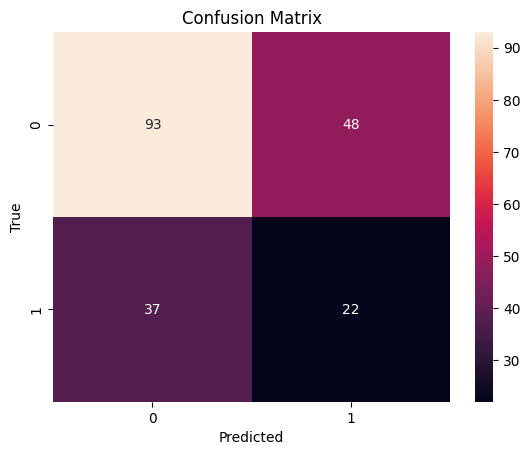

0.5031854790239212


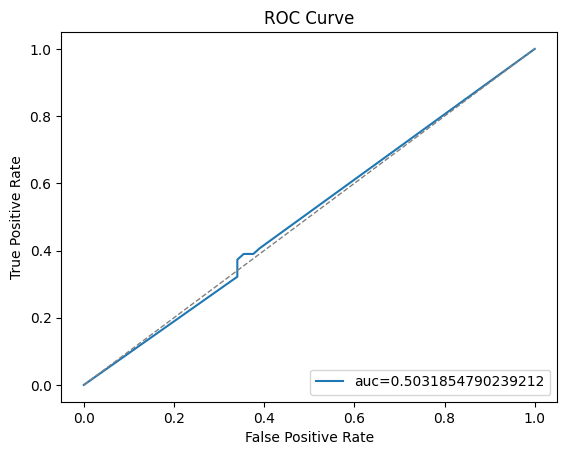

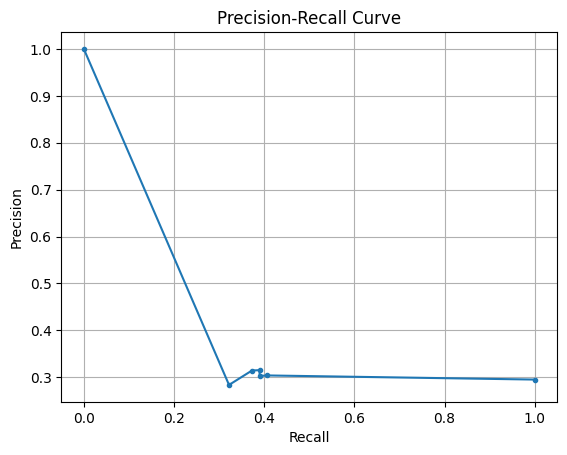

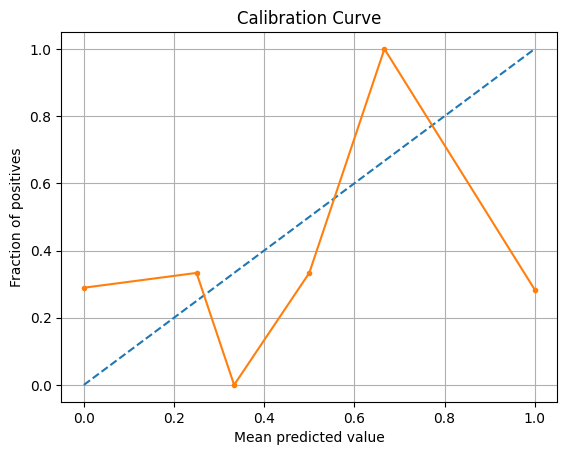

Best params:  {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Best score:  0.6618469612622923
F1:  0.2764227642276423
Precision:  0.265625
Recall:  0.288135593220339
Accuracy:  0.555
Negative predictive value:  0.69
Positive predictive value:  0.27
Cost:  100.75

F1 train:  1.0
Precision train:  1.0
Recall train:  1.0
Accuracy train:  1.0
Negative predictive value train:  1.0
Positive predictive value train:  1.0
Cost train:  0.0
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       141
           1       0.27      0.29      0.28        59

    accuracy                           0.56       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.57      0.56      0.56       200



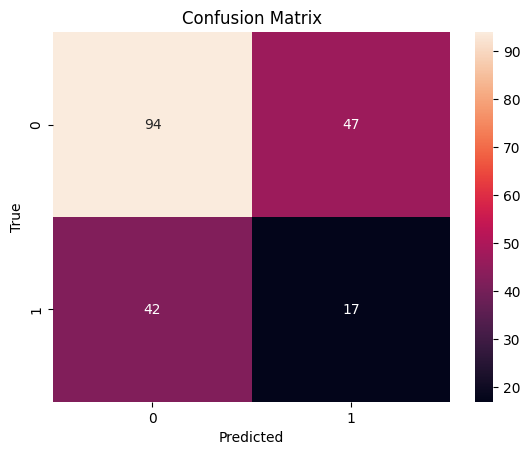

0.4774011299435029


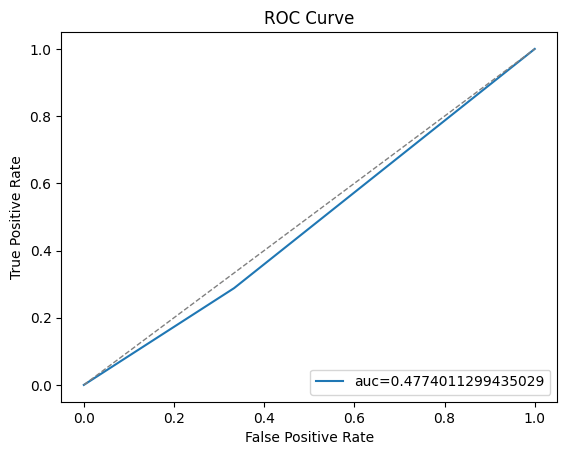

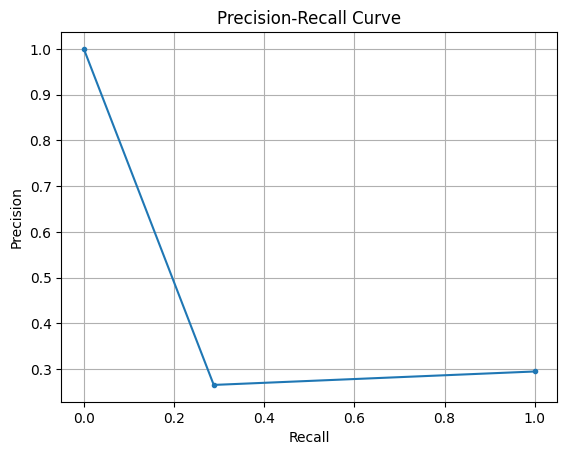

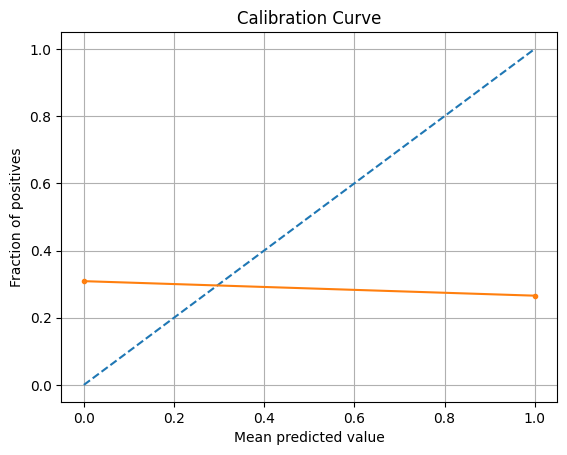


Model:  KNeighborsClassifier
Best params:  {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}
Best score:  0.4619722410036811
F1:  0.3835616438356164
Precision:  0.45901639344262296
Recall:  0.32941176470588235
Accuracy:  0.55
Negative predictive value:  0.59
Positive predictive value:  0.46
Cost:  98.25

F1 train:  1.0
Precision train:  1.0
Recall train:  1.0
Accuracy train:  1.0
Negative predictive value train:  1.0
Positive predictive value train:  1.0
Cost train:  0.0
              precision    recall  f1-score   support

           0       0.59      0.71      0.65       115
           1       0.46      0.33      0.38        85

    accuracy                           0.55       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.53      0.55      0.53       200



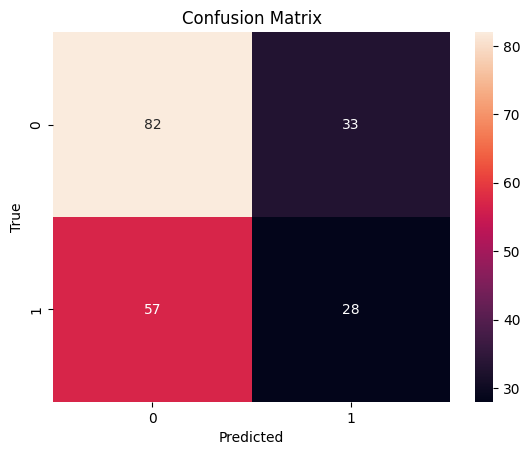

0.5223529411764706


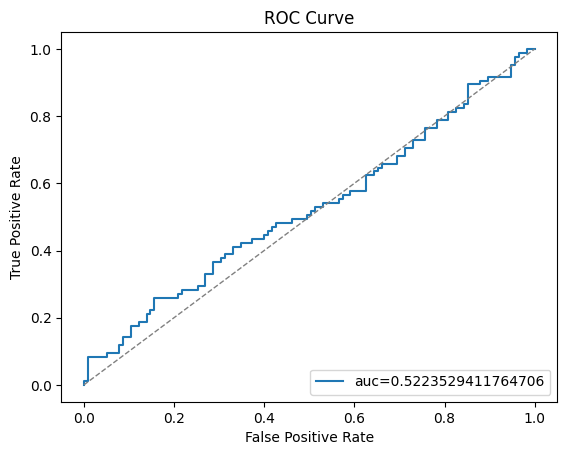

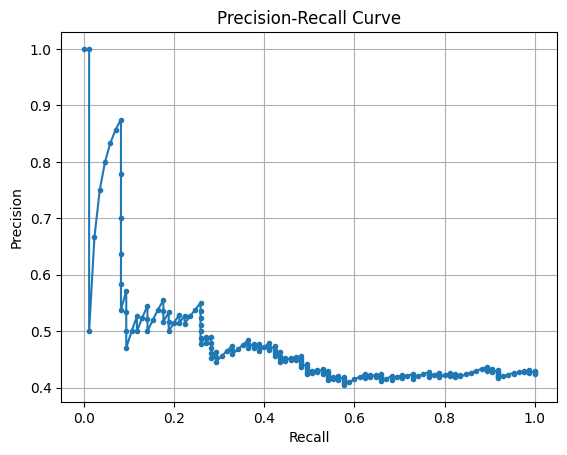

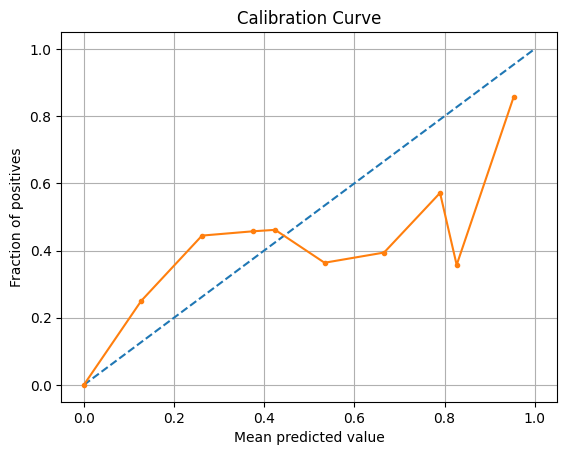

Best params:  {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Best score:  0.4579730578418027
F1:  0.4642857142857143
Precision:  0.46987951807228917
Recall:  0.4588235294117647
Accuracy:  0.55
Negative predictive value:  0.61
Positive predictive value:  0.47
Cost:  101.0

F1 train:  0.6200317965023847
Precision train:  0.6794425087108014
Recall train:  0.5701754385964912
Accuracy train:  0.70125
Negative predictive value train:  0.71
Positive predictive value train:  0.68
Cost train:  262.0
              precision    recall  f1-score   support

           0       0.61      0.62      0.61       115
           1       0.47      0.46      0.46        85

    accuracy                           0.55       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.55      0.55      0.55       200



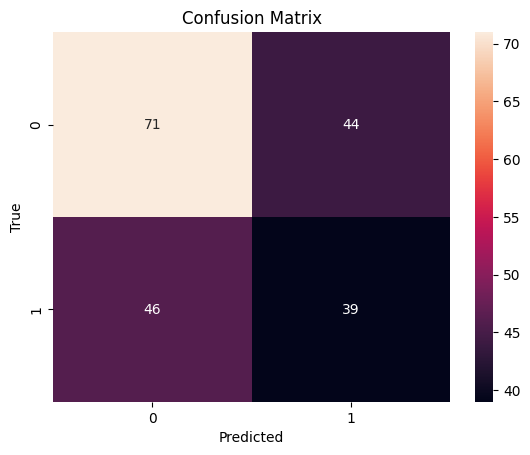

0.5481841432225064


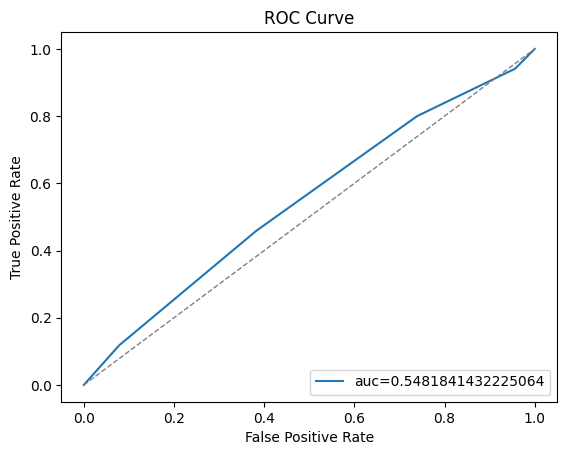

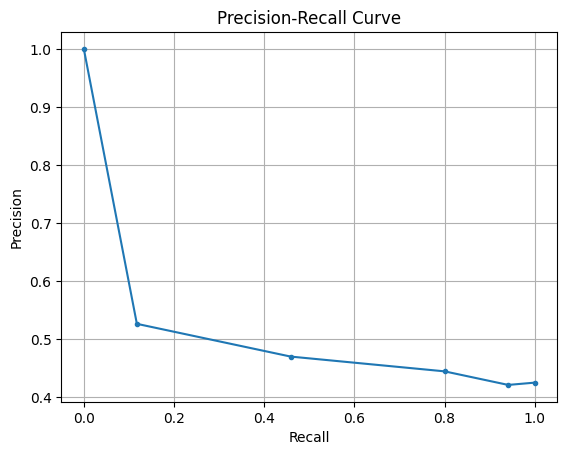

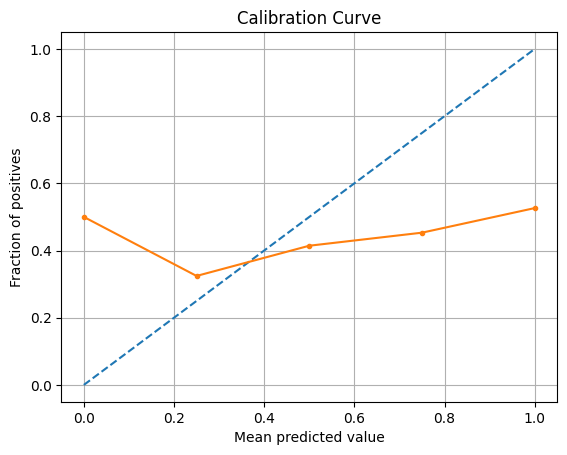

Best params:  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score:  0.6399457671009741
F1:  0.358974358974359
Precision:  0.3146067415730337
Recall:  0.417910447761194
Accuracy:  0.5
Negative predictive value:  0.65
Positive predictive value:  0.31
Cost:  115.25

F1 train:  1.0
Precision train:  1.0
Recall train:  1.0
Accuracy train:  1.0
Negative predictive value train:  1.0
Positive predictive value train:  1.0
Cost train:  0.0
              precision    recall  f1-score   support

           0       0.65      0.54      0.59       133
           1       0.31      0.42      0.36        67

    accuracy                           0.50       200
   macro avg       0.48      0.48      0.47       200
weighted avg       0.54      0.50      0.51       200



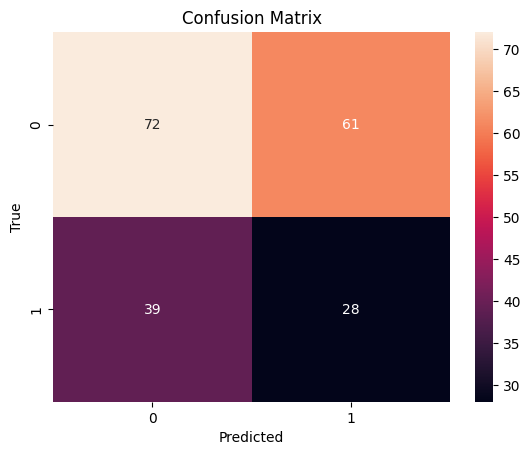

0.42789810346762425


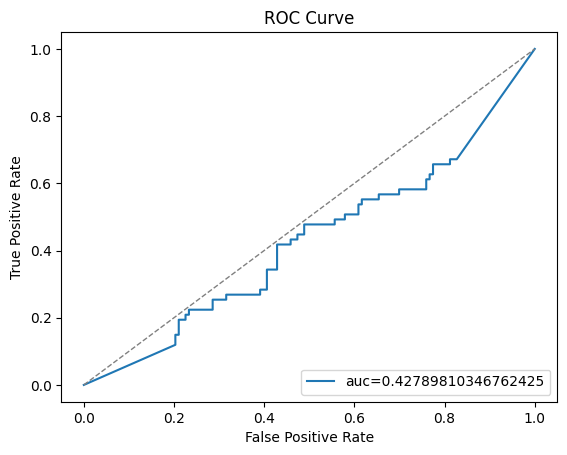

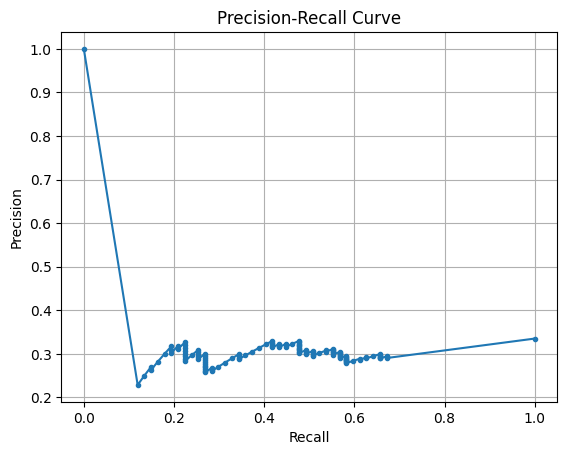

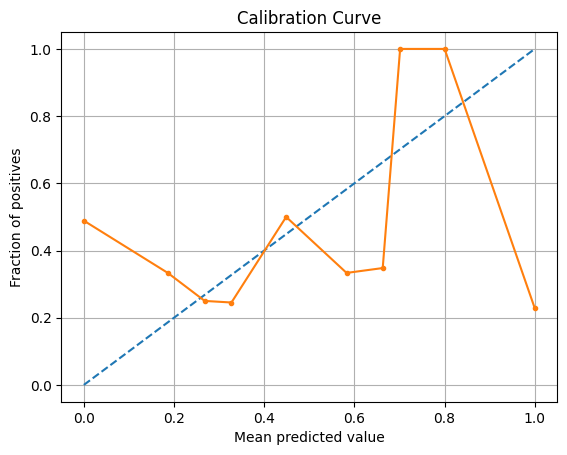

Best params:  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score:  0.6489920633979653
F1:  0.4819277108433735
Precision:  0.40404040404040403
Recall:  0.5970149253731343
Accuracy:  0.57
Negative predictive value:  0.73
Positive predictive value:  0.4
Cost:  100.75

F1 train:  1.0
Precision train:  1.0
Recall train:  1.0
Accuracy train:  1.0
Negative predictive value train:  1.0
Positive predictive value train:  1.0
Cost train:  0.0
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       133
           1       0.40      0.60      0.48        67

    accuracy                           0.57       200
   macro avg       0.57      0.58      0.56       200
weighted avg       0.62      0.57      0.58       200



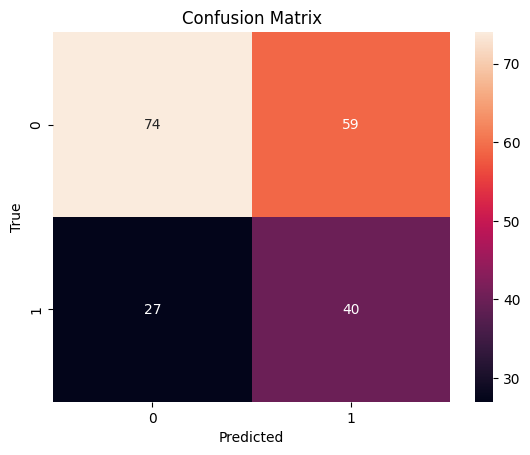

0.5637414431601392


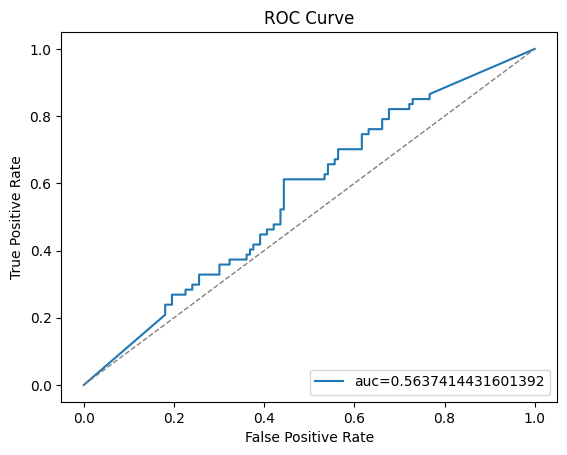

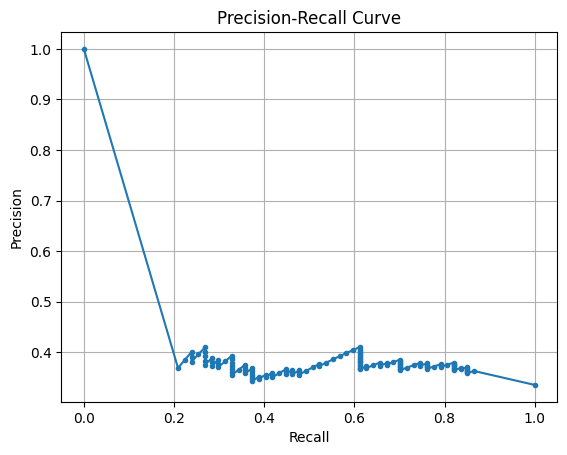

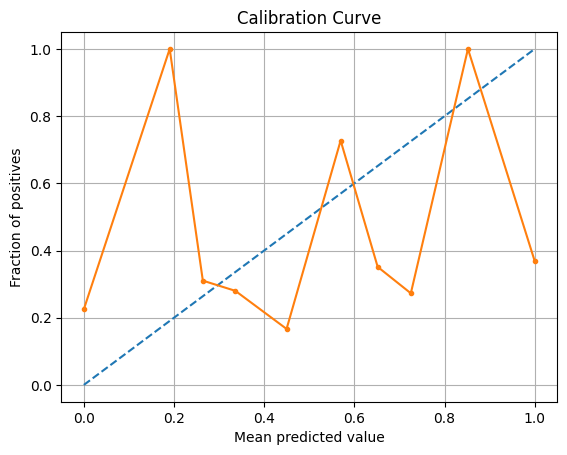

Best params:  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score:  0.6499214168371252
F1:  0.3096774193548387
Precision:  0.25
Recall:  0.4067796610169492
Accuracy:  0.465
Negative predictive value:  0.66
Positive predictive value:  0.25
Cost:  125.0

F1 train:  1.0
Precision train:  1.0
Recall train:  1.0
Accuracy train:  1.0
Negative predictive value train:  1.0
Positive predictive value train:  1.0
Cost train:  0.0
              precision    recall  f1-score   support

           0       0.66      0.49      0.56       141
           1       0.25      0.41      0.31        59

    accuracy                           0.47       200
   macro avg       0.46      0.45      0.44       200
weighted avg       0.54      0.47      0.49       200



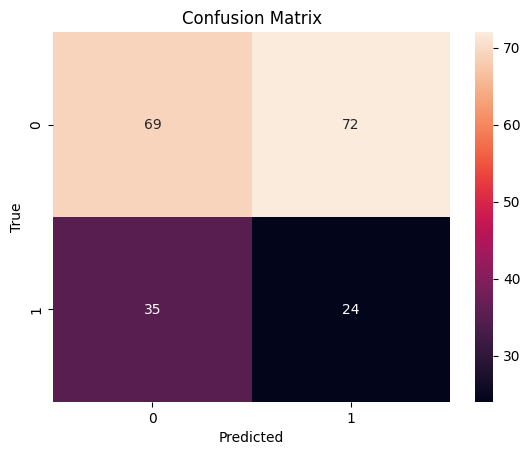

0.40221180430340187


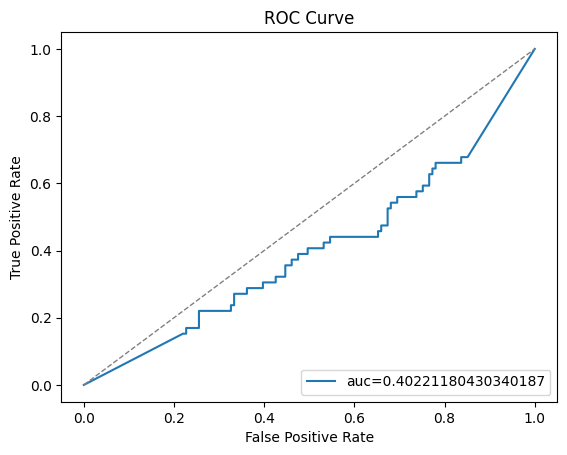

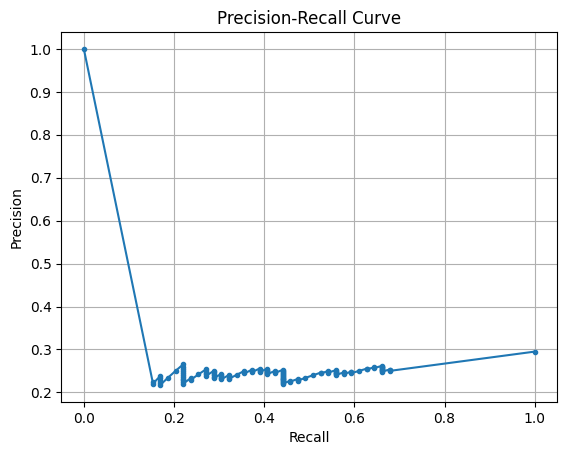

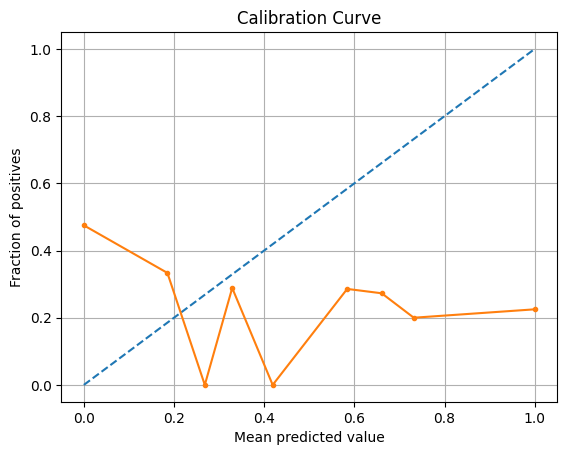

Best params:  {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'distance'}
Best score:  0.6596897958958685
F1:  0.4183006535947713
Precision:  0.3404255319148936
Recall:  0.5423728813559322
Accuracy:  0.555
Negative predictive value:  0.75
Positive predictive value:  0.34
Cost:  104.5

F1 train:  1.0
Precision train:  1.0
Recall train:  1.0
Accuracy train:  1.0
Negative predictive value train:  1.0
Positive predictive value train:  1.0
Cost train:  0.0
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       141
           1       0.34      0.54      0.42        59

    accuracy                           0.56       200
   macro avg       0.54      0.55      0.53       200
weighted avg       0.63      0.56      0.57       200



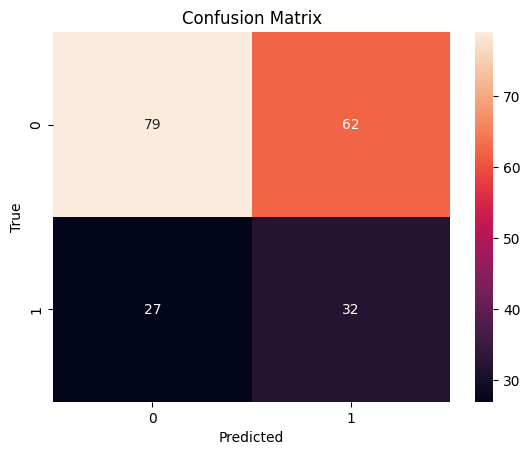

0.5200745281884842


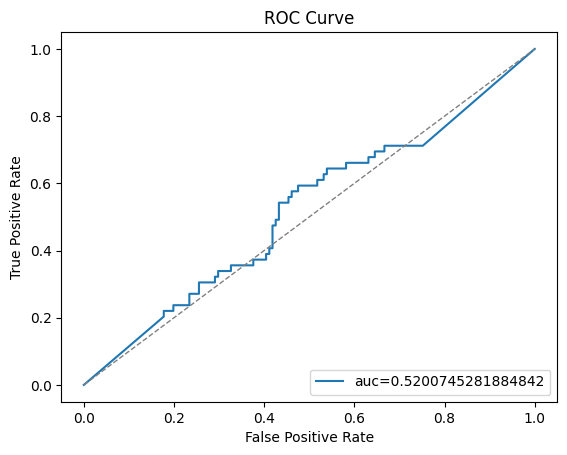

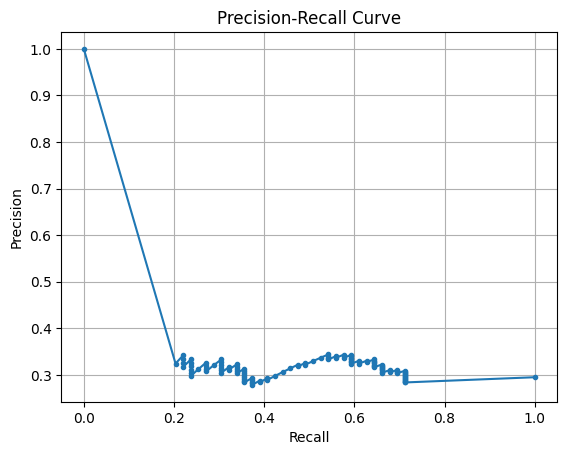

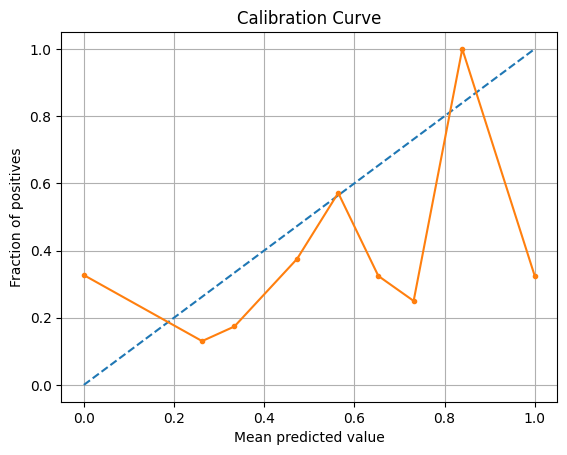

In [319]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
# random forest
from sklearn.ensemble import RandomForestClassifier
# xgboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
#import gridsearchcv
from sklearn.model_selection import GridSearchCV
# classification report
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# XGBoost
from xgboost import XGBClassifier
# ada boost
from sklearn.ensemble import AdaBoostClassifier
# random forest
from sklearn.ensemble import RandomForestClassifier
# knn
from sklearn.neighbors import KNeighborsClassifier
# GAN network
from sklearn.ensemble import VotingClassifier

# no mostrar warnings
import warnings
warnings.filterwarnings('ignore')
models2 = [AdaBoostClassifier(),LogisticRegression(),SVC(probability=True),MLPClassifier(),DecisionTreeClassifier(),KNeighborsClassifier()]
models2_names = ["AdaBoostClassifier","LogisticRegression","SVC","MLPClassifier","DecisionTreeClassifier","KNeighborsClassifier"]
params2 = [{"n_estimators": [100, 200, 300, 400, 500], "learning_rate": [0.01, 0.1, 1, 10, 100], "algorithm": ["SAMME", "SAMME.R"]},
           {},
                {"C": [0.1, 1, 10, 100, 1000], "kernel": ["linear", "poly", "rbf", "sigmoid"], "gamma": ["scale", "auto"]},
                    {"hidden_layer_sizes": [(10,10,10), (100,100,100), (100,100), (3,5), (5,3)], "activation": ["identity", "logistic", "tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "learning_rate": ["constant", "invscaling", "adaptive"]},
                        {"criterion": ["gini", "entropy"], "max_depth": [None, 2, 3, 4, 5, 6, 7, 8, 9, 10], "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10]},
                            {"n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]}]

# entrenar los modelos con el dataset de entrenamiento y validarlos con el dataset de validacion
for i in range(len(models2)):
    warnings.filterwarnings('ignore')
    print("Model: ", models2_names[i])
    TODAS2 = train_model_gridsearch2(models2[i], X_train_todos, X_test_todos, y_train["TRT_60"], y_test["TRT_60"], params2[i],TODAS2)
    SIGNIFICATIVAS2 = train_model_gridsearch2(models2[i], X_train_final, X_test_final, y_train["TRT_60"], y_test["TRT_60"], params2[i],SIGNIFICATIVAS2)
    TODAS3 = train_model_gridsearch2(models2[i], X_train_todos65, X_test_todos, y_train_bi65t, y_test["TRT_65"], params2[i],TODAS3)
    SIGNIFICATIVAS3 =train_model_gridsearch2(models2[i], X_train_final65, X_test_final, y_train_bi65, y_test["TRT_65"], params2[i],SIGNIFICATIVAS3)
    TODAS4 = train_model_gridsearch2(models2[i], X_train_todos70, X_test_todos, y_train_bi70t, y_test["TRT_70"], params2[i],TODAS4)
    SIGNIFICATIVAS4 =train_model_gridsearch2(models2[i], X_train_final70, X_test_final, y_train_bi70, y_test["TRT_70"], params2[i],SIGNIFICATIVAS4)
    print("")

In [320]:
SIGNIFICATIVAS2

Modelo        F1 Precision    Recall Balanced accuracy  \
0      AdaBoostClassifier()  0.108696  0.714286  0.058824          0.520716   
1      LogisticRegression()  0.319328  0.558824  0.223529          0.546547   
2     SVC(probability=True)     0.125  0.545455  0.070588          0.513555   
3           MLPClassifier()  0.084211       0.4  0.047059          0.497442   
4  DecisionTreeClassifier()  0.425806  0.471429  0.388235          0.533248   
5    KNeighborsClassifier()  0.464286   0.46988  0.458824          0.538107   

    NPV   PPV      Time       AUC  \
0  0.59  0.71  0.043105  0.561739   
1   0.6  0.56   0.00316  0.615959   
2  0.58  0.55  0.013939  0.579437   
3  0.57   0.4  0.003155  0.542609   
4   0.6  0.47  0.001233  0.520409   
5  0.61  0.47  0.012031  0.548184   

                                                 FPR  \
0  [0.0, 0.008695652173913044, 0.0086956521739130...   
1  [0.0, 0.0, 0.0, 0.017391304347826087, 0.017391...   
2  [0.0, 0.008695652173913044, 0.0086956521739130...   
3  [0.0, 0.008695652173913044, 0.0173913043478260...   
4  [0.0, 0.2608695652173913, 0.2608695652173913, ...   
5  [0.0, 0.0782608695652174, 0.3826086956521739, ...   

                                                 TPR   PR   RE   Cost  \
0  [0.0, 0.0, 0.023529411764705882, 0.05882352941...  NaN  NaN   82.5   
1  [0.0, 0.011764705882352941, 0.0352941176470588...  NaN  NaN  84.75   
2  [0.0, 0.0, 0.047058823529411764, 0.04705882352...  NaN  NaN  85.25   
3  [0.0, 0.0, 0.0, 0.011764705882352941, 0.011764...  NaN  NaN   88.5   
4  [0.0, 0.29411764705882354, 0.3176470588235294,...  NaN  NaN  98.25   
5  [0.0, 0.11764705882352941, 0.4588235294117647,...  NaN  NaN  101.0   

                                                 FOP  \
0  [0.0, 0.25, 0.3333333333333333, 0.421052631578...   
1  [0.0, 0.5, 0.35294117647058826, 0.375, 0.27027...   
2  [0.42857142857142855, 0.33707865168539325, 0.5...   
3  [0.4, 0.2222222222222222, 0.25, 0.35, 0.352941...   
4  [0.39285714285714285, 0.5, 0.46875, 0.41666666...   
5  [0.5, 0.32432432432432434, 0.4142857142857143,...   

                                                 MPV  
0  [0.0, 0.3619228772440371, 0.47016834882987796,...  
1  [0.04156720200357692, 0.15007620483812903, 0.2...  
2  [0.062025353965225793, 0.14645282617197036, 0....  
3  [0.043376826083365724, 0.15970998684842452, 0....  
4  [0.010416666666666666, 0.11764705882352941, 0....  
5          [0.0, 0.25, 0.5, 0.7499999999999999, 1.0]

In [305]:
X_train_todos.columns

Index(['SAME-TT2R2_MAS3'], dtype='object')

Model:  VotingClassifier(estimators=[('KNN', KNeighborsClassifier()),
                             ('LR', LogisticRegression()),
                             ('MLP', MLPClassifier())])
Best params:  {'voting': 'soft', 'weights': [1, 2, 2]}
Best score:  0.5039533551359723
F1:  0.3623188405797102
Precision:  0.4716981132075472
Recall:  0.29411764705882354
Accuracy:  0.56
Negative predictive value:  0.59
Positive predictive value:  0.47
Cost:  95.0

F1 train:  0.7549668874172185
Precision train:  0.8702290076335878
Recall train:  0.6666666666666666
Accuracy train:  0.815
Negative predictive value train:  0.79
Positive predictive value train:  0.87
Cost train:  156.5
              precision    recall  f1-score   support

           0       0.59      0.76      0.66       115
           1       0.47      0.29      0.36        85

    accuracy                           0.56       200
   macro avg       0.53      0.53      0.51       200
weighted avg       0.54      0.56      0.54       200



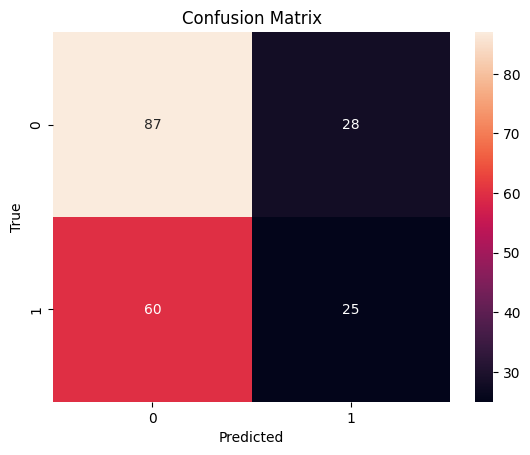

0.5459846547314579


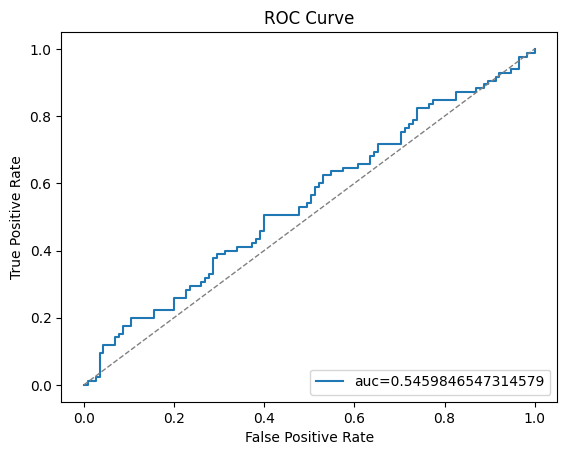

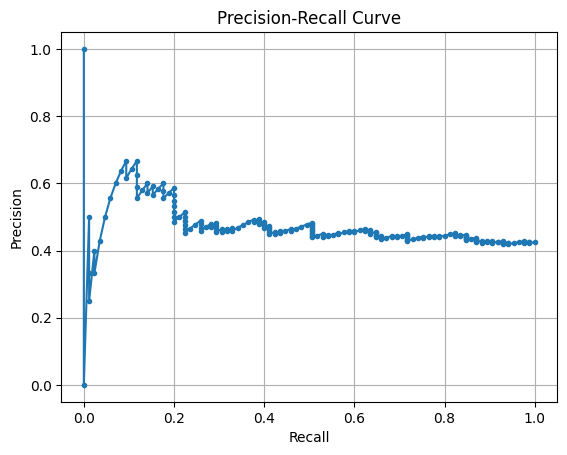

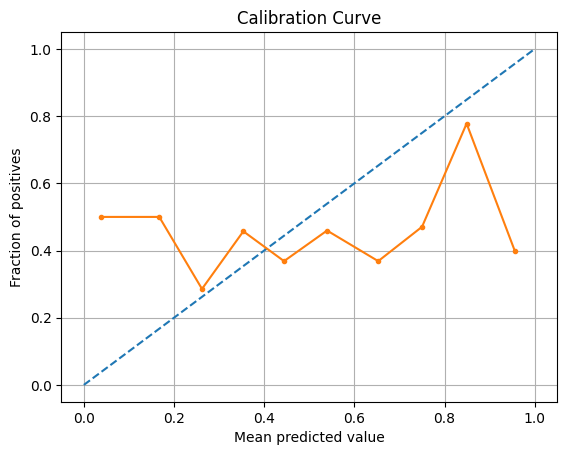

Best params:  {'voting': 'hard', 'weights': [1, 2, 1]}
Best score:  0.4803095081732853
F1:  0.2782608695652174
Precision:  0.5333333333333333
Recall:  0.18823529411764706
Accuracy:  0.585
Negative predictive value:  0.59
Positive predictive value:  0.53
Cost:  86.5

F1 train:  0.2555066079295154
Precision train:  0.5178571428571429
Recall train:  0.1695906432748538
Accuracy train:  0.5775
Negative predictive value train:  0.59
Positive predictive value train:  0.52
Cost train:  351.5
              precision    recall  f1-score   support

           0       0.59      0.88      0.71       115
           1       0.53      0.19      0.28        85

    accuracy                           0.58       200
   macro avg       0.56      0.53      0.49       200
weighted avg       0.57      0.58      0.53       200



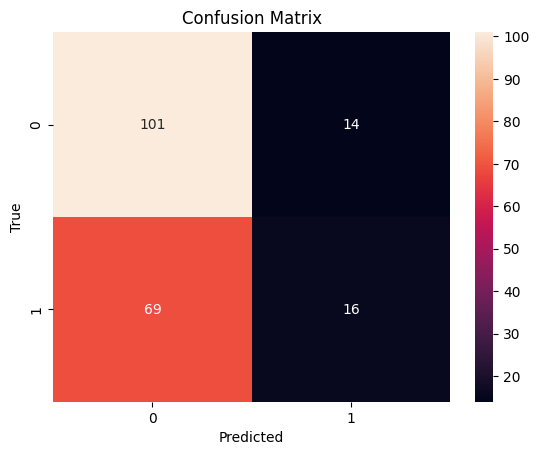

Best params:  {'voting': 'hard', 'weights': [1, 1, 2]}
Best score:  0.6475351221634782
F1:  0.2647058823529412
Precision:  0.2608695652173913
Recall:  0.26865671641791045
Accuracy:  0.5
Negative predictive value:  0.63
Positive predictive value:  0.26
Cost:  112.75

F1 train:  0.85662100456621
Precision train:  0.8300884955752212
Recall train:  0.8849056603773585
Accuracy train:  0.8514664143803217
Negative predictive value train:  0.88
Positive predictive value train:  0.83
Cost train:  181.0
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       133
           1       0.26      0.27      0.26        67

    accuracy                           0.50       200
   macro avg       0.44      0.44      0.44       200
weighted avg       0.50      0.50      0.50       200



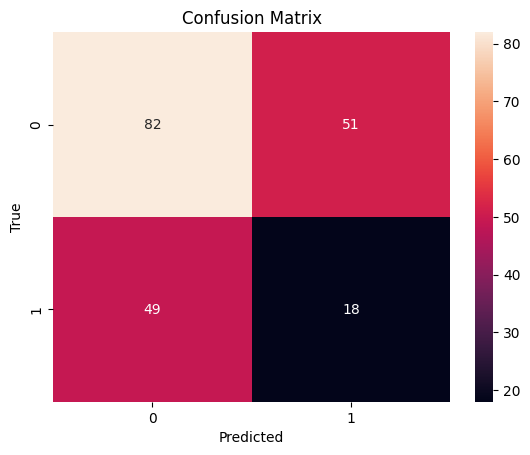

Best params:  {'voting': 'hard', 'weights': [2, 1, 1]}
Best score:  0.6262318734728995
F1:  0.4539007092198581
Precision:  0.43243243243243246
Recall:  0.47761194029850745
Accuracy:  0.615
Negative predictive value:  0.72
Positive predictive value:  0.43
Cost:  87.5

F1 train:  0.7615457115928369
Precision train:  0.7666034155597723
Recall train:  0.7565543071161048
Accuracy train:  0.7615457115928369
Negative predictive value train:  0.76
Positive predictive value train:  0.77
Cost train:  283.75
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       133
           1       0.43      0.48      0.45        67

    accuracy                           0.61       200
   macro avg       0.58      0.58      0.58       200
weighted avg       0.63      0.61      0.62       200



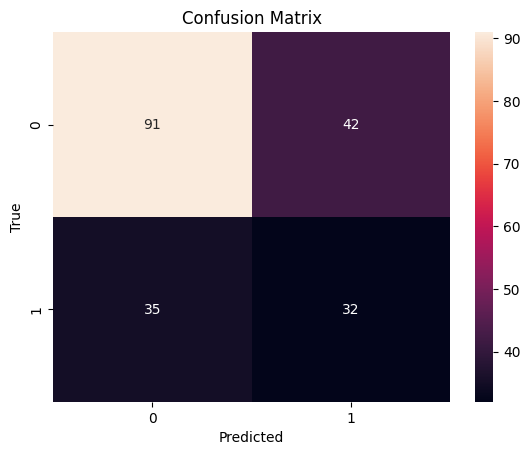

Best params:  {'voting': 'hard', 'weights': [1, 1, 2]}
Best score:  0.7075048830183196
F1:  0.3185840707964602
Precision:  0.3333333333333333
Recall:  0.3050847457627119
Accuracy:  0.615
Negative predictive value:  0.72
Positive predictive value:  0.33
Cost:  86.0

F1 train:  0.8867924528301887
Precision train:  0.8659966499162479
Recall train:  0.9086115992970123
Accuracy train:  0.8837004405286344
Negative predictive value train:  0.9
Positive predictive value train:  0.87
Cost train:  152.0
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       141
           1       0.33      0.31      0.32        59

    accuracy                           0.61       200
   macro avg       0.53      0.52      0.53       200
weighted avg       0.61      0.61      0.61       200



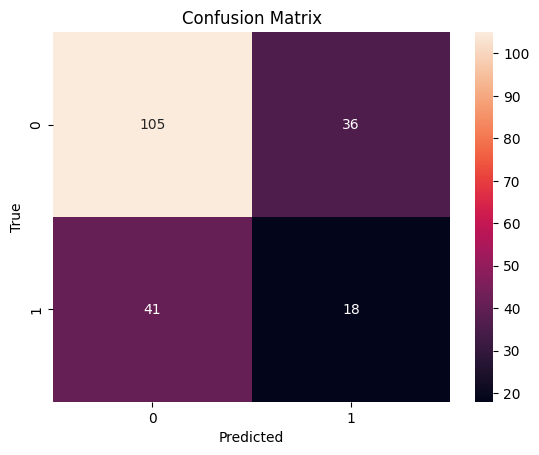

Best params:  {'voting': 'hard', 'weights': [2, 1, 1]}
Best score:  0.6591173552575208
F1:  0.39436619718309857
Precision:  0.3373493975903614
Recall:  0.4745762711864407
Accuracy:  0.57
Negative predictive value:  0.74
Positive predictive value:  0.34
Cost:  99.75

F1 train:  0.7953795379537953
Precision train:  0.767515923566879
Recall train:  0.8253424657534246
Accuracy train:  0.7843478260869565
Negative predictive value train:  0.8
Positive predictive value train:  0.77
Cost train:  284.5
              precision    recall  f1-score   support

           0       0.74      0.61      0.67       141
           1       0.34      0.47      0.39        59

    accuracy                           0.57       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.62      0.57      0.59       200



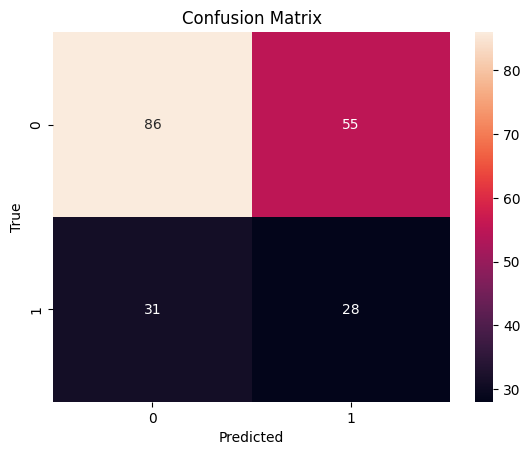

In [321]:
# voting de svc, knn y mlp
models2 = [("KNN", KNeighborsClassifier()), ("LR", LogisticRegression()), ("MLP", MLPClassifier())]
voting = VotingClassifier(estimators=models2)
params2 = {"voting": ["hard", "soft"],"weights": [[1,1,1],[1,2,1],[1,1,2],[1,2,2],[2,1,1],[2,2,1],[2,1,2],[2,2,2]]}
print("Model: ", voting)
TODAS2 = train_model_gridsearch2(voting, X_train_todos, X_test_todos, y_train["TRT_60"], y_test["TRT_60"], params2,TODAS2)
SIGNIFICATIVAS2 = train_model_gridsearch2(voting, X_train_final, X_test_final, y_train["TRT_60"], y_test["TRT_60"], params2,SIGNIFICATIVAS2)
TODAS3 = train_model_gridsearch2(voting, X_train_todos65, X_test_todos, y_train_bi65t, y_test["TRT_65"], params2,TODAS3)
SIGNIFICATIVAS3 =train_model_gridsearch2(voting, X_train_final65, X_test_final, y_train_bi65, y_test["TRT_65"], params2,SIGNIFICATIVAS3)
TODAS4 = train_model_gridsearch2(voting, X_train_todos70, X_test_todos, y_train_bi70t, y_test["TRT_70"], params2,TODAS4)
SIGNIFICATIVAS4 =train_model_gridsearch2(voting, X_train_final70, X_test_final, y_train_bi70, y_test["TRT_70"], params2,SIGNIFICATIVAS4)
print("")

In [332]:
SIGNIFICATIVAS4

Modelo        F1 Precision  \
0                               AdaBoostClassifier()   0.27451  0.325581   
1                               LogisticRegression()  0.405063  0.323232   
2                              SVC(probability=True)  0.435374  0.363636   
3                                    MLPClassifier()  0.352941      0.35   
4                           DecisionTreeClassifier()  0.276423  0.265625   
5                             KNeighborsClassifier()  0.418301  0.340426   
6  VotingClassifier(estimators=[('KNN', KNeighbor...  0.394366  0.337349   

     Recall Balanced accuracy   NPV   PPV      Time       AUC  \
0  0.237288          0.515807  0.71  0.33  0.055642  0.560284   
1  0.542373          0.533598  0.73  0.32  0.001222  0.530833   
2  0.542373          0.572605  0.76  0.36  0.023878  0.560284   
3  0.355932          0.539668  0.73  0.35  0.003099  0.524823   
4  0.288136          0.477401  0.69  0.27  0.001771  0.477401   
5  0.542373          0.551328  0.75  0.34  0.007184  0.520075   
6  0.474576          0.542253  0.74  0.34  0.015304  0.542253   

                                                 FPR  \
0  [0.0, 0.0070921985815602835, 0.014184397163120...   
1  [0.0, 0.0070921985815602835, 0.007092198581560...   
2  [0.0, 0.0070921985815602835, 0.007092198581560...   
3  [0.0, 0.0, 0.0425531914893617, 0.0425531914893...   
4                     [0.0, 0.3333333333333333, 1.0]   
5  [0.0, 0.1773049645390071, 0.1773049645390071, ...   
6                     [0.0, 0.3900709219858156, 1.0]   

                                                 TPR   PR   RE    Cost  \
0  [0.0, 0.0, 0.0, 0.01694915254237288, 0.0169491...  NaN  NaN   81.25   
1  [0.0, 0.0, 0.03389830508474576, 0.033898305084...  NaN  NaN  110.75   
2  [0.0, 0.0, 0.06779661016949153, 0.067796610169...  NaN  NaN    97.0   
3  [0.0, 0.01694915254237288, 0.01694915254237288...  NaN  NaN   86.75   
4                      [0.0, 0.288135593220339, 1.0]  NaN  NaN  100.75   
5  [0.0, 0.2033898305084746, 0.22033898305084745,...  NaN  NaN   104.5   
6                     [0.0, 0.4745762711864407, 1.0]  NaN  NaN   99.75   

                                                 FOP  \
0  [0.0, 0.0, 0.0, 0.17647058823529413, 0.3271604...   
1  [0.0, 0.4, 0.1, 0.25, 0.34375, 0.2727272727272...   
2  [0.21428571428571427, 0.23076923076923078, 0.4...   
3  [0.26804123711340205, 0.3333333333333333, 0.3,...   
4                     [0.3088235294117647, 0.265625]   
5  [0.3269230769230769, 0.13043478260869565, 0.17...   
6          [0.26495726495726496, 0.3373493975903614]   

                                                 MPV  
0  [0.0, 0.3262811214617623, 0.7319192780036863, ...  
1  [0.03389809958538683, 0.17218527192232866, 0.2...  
2  [0.0685131829733884, 0.15808784230361242, 0.24...  
3  [0.01755588912397425, 0.1362652834889348, 0.26...  
4                                         [0.0, 1.0]  
5  [0.0, 0.26230434700345595, 0.33396413488185195...  
6                                         [0.0, 1.0]

In [98]:
# quitar el 6 de todos los dataframes

TODAS2 = TODAS2.drop([6])
SIGNIFICATIVAS2 = SIGNIFICATIVAS2.drop([6])
TODAS3 = TODAS3.drop([6])
SIGNIFICATIVAS3 = SIGNIFICATIVAS3.drop([6])
TODAS4 = TODAS4.drop([6])
SIGNIFICATIVAS4 = SIGNIFICATIVAS4.drop([6])

In [99]:
TODAS2

Modelo        F1 Precision  \
0                               AdaBoostClassifier()   0.10101  0.357143   
1                               LogisticRegression()  0.283465  0.428571   
2                              SVC(probability=True)  0.385093  0.407895   
3                                    MLPClassifier()   0.19469  0.392857   
4                           DecisionTreeClassifier()  0.404762  0.409639   
5                             KNeighborsClassifier()   0.44186  0.436782   
7  VotingClassifier(estimators=[('SVC', SVC(proba...  0.271186  0.484848   

     Recall Balanced accuracy   NPV   PPV        Time       AUC  \
0  0.058824          0.490281  0.57  0.36  133.860188  0.548286   
1  0.211765          0.501535  0.58  0.43   11.230462  0.514987   
2  0.364706          0.486701  0.56  0.41  234.994963  0.507519   
3  0.129412          0.490793  0.57  0.39  337.830614  0.521023   
4       0.4          0.486957  0.56  0.41    11.97271  0.467877   
5  0.447059          0.510486  0.58  0.44    7.450612  0.485831   
7  0.188235          0.520205  0.59  0.48   61.279582  0.520205   

                                                 FPR  \
0  [0.0, 0.017391304347826087, 0.0260869565217391...   
1  [0.0, 0.008695652173913044, 0.0086956521739130...   
2  [0.0, 0.0, 0.0, 0.017391304347826087, 0.017391...   
3  [0.0, 0.008695652173913044, 0.0086956521739130...   
4  [0.0, 0.1826086956521739, 0.19130434782608696,...   
5  [0.0, 0.10434782608695652, 0.1391304347826087,...   
7                    [0.0, 0.14782608695652175, 1.0]   

                                                 TPR   PR   RE    Cost  \
0  [0.0, 0.023529411764705882, 0.0470588235294117...  NaN  NaN   91.25   
1  [0.0, 0.0, 0.023529411764705882, 0.02352941176...  NaN  NaN    97.0   
2  [0.0, 0.011764705882352941, 0.0235294117647058...  NaN  NaN  110.25   
3  [0.0, 0.0, 0.011764705882352941, 0.01176470588...  NaN  NaN   95.25   
4  [0.0, 0.1411764705882353, 0.16470588235294117,...  NaN  NaN  112.25   
5  [0.0, 0.15294117647058825, 0.15294117647058825...  NaN  NaN  108.25   
7                    [0.0, 0.18823529411764706, 1.0]  NaN  NaN   90.25   

                                                 FOP  \
0  [0.3333333333333333, 0.0, 0.4, 0.4565217391304...   
1  [0.5, 0.5, 0.375, 0.17647058823529413, 0.54838...   
2  [0.0, 0.5, 0.35294117647058826, 0.466666666666...   
3  [0.6666666666666666, 0.3333333333333333, 0.4, ...   
4  [0.4782608695652174, 1.0, 0.30434782608695654,...   
5  [0.6129032258064516, 1.0, 0.25, 0.328571428571...   
7         [0.41317365269461076, 0.48484848484848486]   

                                                 MPV  
0  [0.0, 0.14244345582610057, 0.23650133473981083...  
1  [0.018743797978201943, 0.1934896763144487, 0.2...  
2  [0.0, 0.1514706018658462, 0.2655901801272367, ...  
3  [0.044402253873939763, 0.16512712408071065, 0....  
4  [0.0, 0.2, 0.2618203309692672, 0.3599999999999...  
5  [0.0, 0.19847026504966844, 0.2697984237077154,...  
7                                         [0.0, 1.0]

In [101]:
SIGNIFICATIVAS2

Modelo        F1 Precision  \
0                               AdaBoostClassifier()  0.108696  0.714286   
1                               LogisticRegression()     0.375   0.55814   
2                              SVC(probability=True)  0.357143  0.361446   
3                                    MLPClassifier()       0.0       0.0   
4                           DecisionTreeClassifier()  0.342105   0.38806   
5                             KNeighborsClassifier()  0.539326  0.516129   
7  VotingClassifier(estimators=[('SVC', SVC(proba...  0.129032      0.75   

     Recall Balanced accuracy   NPV   PPV        Time       AUC  \
0  0.058824          0.520716  0.59  0.71  105.735368  0.564655   
1  0.282353          0.558568  0.61  0.56    6.583089  0.614834   
2  0.352941          0.446036  0.53  0.36  245.330354  0.528286   
3       0.0               0.5  0.57   NaN  292.875223   0.49422   
4  0.305882           0.47468  0.56  0.39   10.897742  0.475141   
5  0.564706          0.586701  0.65  0.52    6.189422  0.591714   
7  0.070588          0.526598  0.59  0.75   51.287086  0.617084   

                                                 FPR  \
0  [0.0, 0.008695652173913044, 0.0173913043478260...   
1  [0.0, 0.0, 0.0, 0.008695652173913044, 0.008695...   
2  [0.0, 0.008695652173913044, 0.0173913043478260...   
3  [0.0, 0.0, 0.0, 0.02608695652173913, 0.0260869...   
4  [0.0, 0.017391304347826087, 0.0434782608695652...   
5  [0.0, 0.06956521739130435, 0.391304347826087, ...   
7  [0.0, 0.0, 0.008695652173913044, 0.00869565217...   

                                                 TPR   PR   RE    Cost  \
0  [0.0, 0.03529411764705882, 0.04705882352941176...  NaN  NaN    82.5   
1  [0.0, 0.011764705882352941, 0.0235294117647058...  NaN  NaN   84.75   
2  [0.0, 0.0, 0.0, 0.023529411764705882, 0.023529...  NaN  NaN  121.25   
3  [0.0, 0.011764705882352941, 0.0470588235294117...  NaN  NaN    85.0   
4  [0.0, 0.0, 0.0, 0.047058823529411764, 0.070588...  NaN  NaN  110.25   
5  [0.0, 0.10588235294117647, 0.5647058823529412,...  NaN  NaN   93.25   
7  [0.0, 0.011764705882352941, 0.0117647058823529...  NaN  NaN    81.5   

                                                 FOP  \
0  [0.0, 0.25, 0.0, 0.35294117647058826, 0.411764...   
1  [0.0, 0.4, 0.35294117647058826, 0.428571428571...   
2  [0.5, 0.6666666666666666, 0.375, 0.25, 0.37142...   
3  [0.0, 0.75, 0.4, 0.375, 0.42857142857142855, 0...   
4  [0.2857142857142857, 0.5, 0.75, 0.459459459459...   
5  [0.3225806451612903, 0.35526315789473684, 0.51...   
7  [0.2857142857142857, 0.36363636363636365, 0.3,...   

                                                 MPV  
0  [0.0, 0.3721848475797591, 0.47137124519200685,...  
1  [0.04508184928631202, 0.14565153085426624, 0.2...  
2  [0.039086490806246495, 0.15741078686877186, 0....  
3  [0.0, 0.16761133664921235, 0.26456719130086354...  
4  [0.02552619793999104, 0.14688759516345726, 0.2...  
5  [0.0, 0.33333333333333304, 0.6666666666666661,...  
7  [0.03986456556720629, 0.16469103448329606, 0.2...

In [102]:
TODAS3

Modelo        F1 Precision  \
0                               AdaBoostClassifier()  0.294118  0.289855   
1                               LogisticRegression()  0.304636   0.27381   
2                              SVC(probability=True)  0.345865  0.348485   
3                                    MLPClassifier()  0.272727  0.276923   
4                           DecisionTreeClassifier()  0.366013  0.325581   
5                             KNeighborsClassifier()  0.358974  0.314607   
7  VotingClassifier(estimators=[('SVC', SVC(proba...  0.290076  0.296875   

     Recall Balanced accuracy   NPV   PPV        Time       AUC  \
0  0.298507          0.465043  0.64  0.29  135.254465  0.496016   
1  0.343284          0.442318  0.62  0.27   15.230898   0.43609   
2  0.343284          0.509988  0.67  0.35  259.789216  0.471159   
3  0.268657          0.457637  0.64  0.28  454.407711  0.482886   
4   0.41791           0.49091  0.66  0.33    12.76556  0.473291   
5   0.41791          0.479632  0.65  0.31    8.375351  0.427898   
7  0.283582          0.472618  0.65   0.3   74.424209  0.472618   

                                                 FPR  \
0  [0.0, 0.0, 0.007518796992481203, 0.00751879699...   
1  [0.0, 0.007518796992481203, 0.0150375939849624...   
2  [0.0, 0.0, 0.03759398496240601, 0.037593984962...   
3  [0.0, 0.0, 0.045112781954887216, 0.04511278195...   
4  [0.0, 0.3383458646616541, 0.38345864661654133,...   
5  [0.0, 0.20300751879699247, 0.20300751879699247...   
7                     [0.0, 0.3383458646616541, 1.0]   

                                                 TPR   PR   RE    Cost  \
0  [0.0, 0.014925373134328358, 0.0149253731343283...  NaN  NaN  108.25   
1  [0.0, 0.0, 0.0, 0.014925373134328358, 0.014925...  NaN  NaN  120.25   
2  [0.0, 0.014925373134328358, 0.0149253731343283...  NaN  NaN   97.75   
3  [0.0, 0.014925373134328358, 0.0149253731343283...  NaN  NaN  107.75   
4  [0.0, 0.26865671641791045, 0.29850746268656714...  NaN  NaN   111.5   
5  [0.0, 0.11940298507462686, 0.14925373134328357...  NaN  NaN  115.25   
7                     [0.0, 0.2835820895522388, 1.0]  NaN  NaN  104.25   

                                                 FOP  \
0  [0.125, 0.0, 0.3333333333333333, 0.37037037037...   
1  [0.25, 0.2, 0.38461538461538464, 0.45454545454...   
2  [0.2857142857142857, 0.5, 0.47368421052631576,...   
3  [0.36893203883495146, 0.25, 0.0, 0.4, 0.5, 0.2...   
4  [0.3493975903614458, 0.0, 0.5714285714285714, ...   
5  [0.4888888888888889, 0.3333333333333333, 0.25,...   
7                    [0.35294117647058826, 0.296875]   

                                                 MPV  
0  [0.048859538705866117, 0.18874259860522713, 0....  
1  [0.022979132178616045, 0.1630426836732886, 0.2...  
2  [0.07006545049752126, 0.16401058876532332, 0.2...  
3  [0.01559880069222771, 0.14607502879964443, 0.2...  
4  [0.0, 0.14285714285714285, 0.25, 0.35757575757...  
5  [0.0, 0.1862510583442424, 0.26810844590760385,...  
7                                         [0.0, 1.0]

In [103]:
SIGNIFICATIVAS3

Modelo        F1 Precision  \
0                               AdaBoostClassifier()  0.301587  0.322034   
1                               LogisticRegression()  0.417178  0.354167   
2                              SVC(probability=True)    0.4875  0.419355   
3                                    MLPClassifier()   0.48951  0.460526   
4                           DecisionTreeClassifier()  0.283688   0.27027   
5                             KNeighborsClassifier()  0.481928   0.40404   
7  VotingClassifier(estimators=[('SVC', SVC(proba...  0.447205  0.382979   

     Recall Balanced accuracy   NPV   PPV        Time       AUC  \
0  0.283582          0.491415  0.66  0.32  113.671452  0.548199   
1  0.507463          0.520649  0.68  0.35     6.52324  0.529009   
2   0.58209          0.588037  0.74  0.42   77.058201  0.598923   
3  0.522388          0.607059  0.74  0.46  385.831473  0.604758   
4  0.298507          0.446246  0.63  0.27    9.999791  0.430311   
5  0.597015          0.576703  0.73   0.4    6.934196  0.563741   
7  0.537313          0.550612  0.71  0.38   64.665816  0.550612   

                                                 FPR  \
0  [0.0, 0.007518796992481203, 0.0300751879699248...   
1  [0.0, 0.007518796992481203, 0.0075187969924812...   
2  [0.0, 0.0, 0.007518796992481203, 0.00751879699...   
3  [0.0, 0.0, 0.015037593984962405, 0.01503759398...   
4  [0.0, 0.3609022556390977, 0.37593984962406013,...   
5  [0.0, 0.18045112781954886, 0.18045112781954886...   
7                    [0.0, 0.43609022556390975, 1.0]   

                                                 TPR   PR   RE    Cost  \
0  [0.0, 0.0, 0.0, 0.014925373134328358, 0.014925...  NaN  NaN    98.0   
1  [0.0, 0.0, 0.029850746268656716, 0.02985074626...  NaN  NaN   110.5   
2  [0.0, 0.014925373134328358, 0.0149253731343283...  NaN  NaN    95.5   
3  [0.0, 0.014925373134328358, 0.0149253731343283...  NaN  NaN   83.25   
4  [0.0, 0.23880597014925373, 0.2537313432835821,...  NaN  NaN   114.5   
5  [0.0, 0.208955223880597, 0.23880597014925373, ...  NaN  NaN  100.75   
7                     [0.0, 0.5373134328358209, 1.0]  NaN  NaN   103.5   

                                                 FOP  \
0  [0.0, 0.0, 0.0, 0.37012987012987014, 0.2702702...   
1  [0.25, 0.4, 0.23076923076923078, 0.25, 0.42307...   
2  [0.25, 0.3076923076923077, 0.3, 0.238095238095...   
3  [0.26744186046511625, 0.18181818181818182, 0.2...   
4  [0.38738738738738737, 0.0, 0.2, 0.375, 0.42857...   
5  [0.225, 1.0, 0.3103448275862069, 0.28, 0.16666...   
7          [0.29245283018867924, 0.3829787234042553]   

                                                 MPV  
0  [0.016709583722427073, 0.5527342878478234, 0.7...  
1  [0.04432693696783713, 0.1646238874899172, 0.26...  
2  [0.05487696999541355, 0.15613107460104184, 0.2...  
3  [0.014713328366209977, 0.15276174157474676, 0....  
4  [0.0, 0.25, 0.3333333333333333, 0.5, 0.6666666...  
5  [0.0, 0.19044283804372547, 0.263960007784415, ...  
7                                         [0.0, 1.0]

In [104]:
TODAS4

Modelo        F1 Precision  \
0                               AdaBoostClassifier()  0.260163      0.25   
1                               LogisticRegression()       0.3  0.259259   
2                              SVC(probability=True)  0.354839  0.338462   
3                                    MLPClassifier()  0.348485  0.315068   
4                           DecisionTreeClassifier()   0.38806  0.346667   
5                             KNeighborsClassifier()  0.309677      0.25   
7  VotingClassifier(estimators=[('SVC', SVC(proba...  0.311475  0.301587   

     Recall Balanced accuracy   NPV   PPV        Time       AUC  \
0  0.271186           0.46538  0.68  0.25  143.928627  0.490203   
1  0.355932            0.4652  0.68  0.26   15.396258  0.449814   
2  0.372881          0.533958  0.73  0.34  276.136075  0.518933   
3  0.389831           0.51761  0.72  0.32   489.87582  0.553913   
4  0.440678           0.54658  0.74  0.35   12.521676  0.527888   
5   0.40678          0.448071  0.66  0.25    8.697447  0.402212   
7  0.322034          0.504989  0.71   0.3   76.726441  0.515807   

                                                 FPR  \
0  [0.0, 0.0070921985815602835, 0.007092198581560...   
1  [0.0, 0.0070921985815602835, 0.021276595744680...   
2  [0.0, 0.0070921985815602835, 0.035460992907801...   
3  [0.0, 0.0425531914893617, 0.05673758865248227,...   
4  [0.0, 0.3262411347517731, 0.3333333333333333, ...   
5  [0.0, 0.2198581560283688, 0.22695035460992907,...   
7  [0.0, 0.0070921985815602835, 0.035460992907801...   

                                                 TPR   PR   RE   Cost  \
0  [0.0, 0.0, 0.01694915254237288, 0.016949152542...  NaN  NaN  103.0   
1  [0.0, 0.0, 0.0, 0.03389830508474576, 0.0338983...  NaN  NaN  113.0   
2  [0.0, 0.0, 0.0, 0.01694915254237288, 0.0169491...  NaN  NaN  90.75   
3  [0.0, 0.05084745762711865, 0.05084745762711865...  NaN  NaN   98.5   
4  [0.0, 0.3898305084745763, 0.4067796610169492, ...  NaN  NaN  94.25   
5  [0.0, 0.15254237288135594, 0.15254237288135594...  NaN  NaN  125.0   
7  [0.0, 0.0, 0.0, 0.03389830508474576, 0.0338983...  NaN  NaN   95.0   

                                                 FOP  \
0  [0.5, 0.25, 0.09090909090909091, 0.33333333333...   
1  [0.14285714285714285, 0.6666666666666666, 0.42...   
2  [0.2916666666666667, 0.4230769230769231, 0.181...   
3  [0.2926829268292683, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.2807017543859649, 0.0, 0.3333333333333333, ...   
5  [0.475, 0.3333333333333333, 0.0, 0.28846153846...   
7  [0.25, 0.38095238095238093, 0.1818181818181818...   

                                                 MPV  
0  [0.01927272874395959, 0.14050510235952704, 0.2...  
1  [0.05333962911316751, 0.15331631610304136, 0.2...  
2  [0.056610625845030044, 0.14779538853172638, 0....  
3  [0.0018397670076388001, 0.10654255786249713, 0...  
4  [0.0, 0.2, 0.25, 0.3333333333333333, 0.5, 0.6,...  
5  [0.0, 0.1853390734373174, 0.2683054142036741, ...  
7  [0.05428421027611427, 0.1551468617687458, 0.24...

In [105]:
SIGNIFICATIVAS4

Modelo        F1 Precision  \
0                               AdaBoostClassifier()   0.27451  0.325581   
1                               LogisticRegression()  0.397436  0.319588   
2                              SVC(probability=True)  0.435374  0.363636   
3                                    MLPClassifier()  0.405797   0.35443   
4                           DecisionTreeClassifier()  0.280992  0.274194   
5                             KNeighborsClassifier()  0.418301  0.340426   
7  VotingClassifier(estimators=[('SVC', SVC(proba...   0.38961  0.315789   

     Recall Balanced accuracy   NPV   PPV        Time       AUC  \
0  0.237288          0.515807  0.71  0.33  113.232768  0.560284   
1  0.525424          0.528669  0.73  0.32    7.903879  0.528669   
2  0.542373          0.572605  0.76  0.36   90.688404  0.560404   
3  0.474576          0.556437  0.74  0.35  412.722897  0.540089   
4  0.288136          0.484493   0.7  0.27   10.211285  0.484493   
5  0.542373          0.551328  0.75  0.34     7.39886  0.520075   
7  0.508475          0.523741  0.72  0.32   69.882802  0.523741   

                                                 FPR  \
0  [0.0, 0.0070921985815602835, 0.014184397163120...   
1  [0.0, 0.0070921985815602835, 0.007092198581560...   
2  [0.0, 0.0070921985815602835, 0.007092198581560...   
3  [0.0, 0.0070921985815602835, 0.021276595744680...   
4                     [0.0, 0.3191489361702128, 1.0]   
5  [0.0, 0.1773049645390071, 0.1773049645390071, ...   
7                    [0.0, 0.46099290780141844, 1.0]   

                                                 TPR   PR   RE    Cost  \
0  [0.0, 0.0, 0.0, 0.01694915254237288, 0.0169491...  NaN  NaN   81.25   
1  [0.0, 0.0, 0.03389830508474576, 0.033898305084...  NaN  NaN   110.5   
2  [0.0, 0.0, 0.06779661016949153, 0.067796610169...  NaN  NaN    97.0   
3  [0.0, 0.0, 0.0, 0.01694915254237288, 0.0169491...  NaN  NaN   94.75   
4                      [0.0, 0.288135593220339, 1.0]  NaN  NaN   98.25   
5  [0.0, 0.2033898305084746, 0.22033898305084745,...  NaN  NaN   104.5   
7                     [0.0, 0.5084745762711864, 1.0]  NaN  NaN  110.25   

                                                 FOP  \
0  [0.0, 0.0, 0.0, 0.17647058823529413, 0.3271604...   
1  [0.0, 0.4, 0.17647058823529413, 0.238095238095...   
2  [0.2, 0.28125, 0.4444444444444444, 0.15, 0.095...   
3  [0.2808988764044944, 0.3, 0.0, 0.3333333333333...   
4         [0.30434782608695654, 0.27419354838709675]   
5  [0.3269230769230769, 0.13043478260869565, 0.17...   
7           [0.2761904761904762, 0.3157894736842105]   

                                                 MPV  
0  [0.0, 0.3262811214617623, 0.7319192780036863, ...  
1  [0.036286298479082206, 0.16432321604077677, 0....  
2  [0.0582604613920188, 0.15025349865764218, 0.25...  
3  [0.01014297437876246, 0.16040277392345004, 0.2...  
4                                         [0.0, 1.0]  
5  [0.0, 0.26230434700345595, 0.33396413488185195...  
7                                         [0.0, 1.0]

In [285]:
# guardar los resultados en un csv
TODAS2.to_csv("TODAS2.csv", index=False)
SIGNIFICATIVAS2.to_csv("SIGNIFICATIVAS2.csv", index=False)
TODAS3.to_csv("TODAS3.csv", index=False)
SIGNIFICATIVAS3.to_csv("SIGNIFICATIVAS3.csv", index=False)
TODAS4.to_csv("TODAS4.csv", index=False)
SIGNIFICATIVAS4.to_csv("SIGNIFICATIVAS4.csv", index=False)

In [286]:
TODAS2.mean()

Modelo               NaN
F1                   NaN
Precision            NaN
Recall               NaN
Balanced accuracy    NaN
NPV                  NaN
PPV                  NaN
Time                 NaN
AUC                  NaN
FPR                  NaN
TPR                  NaN
PR                   NaN
RE                   NaN
Cost                 NaN
dtype: object

In [287]:
SIGNIFICATIVAS2.mean()

Modelo               NaN
F1                   NaN
Precision            NaN
Recall               NaN
Balanced accuracy    NaN
NPV                  NaN
PPV                  NaN
Time                 NaN
AUC                  NaN
FPR                  NaN
TPR                  NaN
PR                   NaN
RE                   NaN
Cost                 NaN
dtype: object

In [109]:
TODAS3.mean()

F1                     0.318916
Precision              0.303734
Recall                 0.339019
Balanced accuracy      0.474021
NPV                    0.647143
PPV                    0.304286
Time                 137.178201
AUC                    0.465709
PR                          NaN
RE                          NaN
Cost                 109.285714
dtype: float64

In [110]:
SIGNIFICATIVAS3.mean()


F1                     0.415514
Precision              0.373339
Recall                 0.475480
Balanced accuracy      0.540103
NPV                    0.698571
PPV                    0.371429
Time                  94.954881
AUC                    0.546508
PR                          NaN
RE                          NaN
Cost                 100.857143
dtype: float64

In [111]:
TODAS4.mean()

F1                     0.324671
Precision              0.294435
Recall                 0.365617
Balanced accuracy      0.497398
NPV                    0.702857
PPV                    0.295714
Time                 146.183192
AUC                    0.494110
PR                          NaN
RE                          NaN
Cost                 102.785714
dtype: float64

In [112]:
SIGNIFICATIVAS4.mean()

F1                     0.371717
Precision              0.327663
Recall                 0.445521
Balanced accuracy      0.533297
NPV                    0.730000
PPV                    0.327143
Time                 101.720128
AUC                    0.531108
PR                          NaN
RE                          NaN
Cost                  99.500000
dtype: float64